## Import Libraries

In [ ]:
# !pip install torch==2.0.1+cu118 torchvision torchaudio torchtext torchdata --index-url https://download.pytorch.org/whl/cu118

# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.1+cu118.html

# !pip install torch_geometric torch_geometric_temporal

# !conda install scipy==1.11.2 --yes

In [ ]:
import torch

import numpy as np
import scipy

import matplotlib
import matplotlib.pyplot as plt

import networkx as nx

In [ ]:
print(torch.__version__)

print(np.__version__)
print(scipy.__version__)

print(matplotlib.__version__)
print(nx.__version__)

2.0.1+cu118
1.23.5
1.11.3
3.7.1
3.1


## Load Dataset

In [ ]:
# ds = 'pemsbay'
ds = 'metrla'
# ds = 'pemsd7'
# ds = 'pemsd8'

In [ ]:
import os

if ds == 'pemsd7' and not os.path.exists('PeMSD7_Full.zip'):
  !wget https://github.com/VeritasYin/STGCN_IJCAI-18/raw/master/dataset/PeMSD7_Full.zip -O PeMSD7_Full.zip --no-check-certificate
  !unzip -o PeMSD7_Full.zip -d ./


if ds == 'pemsd8':
  if not os.path.exists('PEMS08.csv'):
    !wget https://github.com/guoshnBJTU/ASTGNN/raw/main/data/PEMS08/PEMS08.csv -O PEMS08.csv --no-check-certificate
  if not os.path.exists('PEMS08.npz'):
    !wget https://github.com/guoshnBJTU/ASTGNN/raw/main/data/PEMS08/PEMS08.npz -O PEMS08.npz --no-check-certificate


if ds == 'pemsbay' and not os.path.exists('PEMS-BAY.zip'):
  !wget https://graphmining.ai/temporal_datasets/PEMS-BAY.zip -O PEMS-BAY.zip --no-check-certificate
  !unzip -o PEMS-BAY.zip -d ./


if ds == 'metrla' and not os.path.exists('METR-LA.zip'):
  !wget https://graphmining.ai/temporal_datasets/METR-LA.zip -O METR-LA.zip --no-check-certificate
  !unzip -o METR-LA.zip -d ./

--2023-10-19 02:29:32--  https://graphmining.ai/temporal_datasets/METR-LA.zip
Resolving graphmining.ai (graphmining.ai)... 199.188.200.254
Connecting to graphmining.ai (graphmining.ai)|199.188.200.254|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 14226553 (14M) [application/zip]
Saving to: ‘METR-LA.zip’

METR-LA.zip         100%[===================>]  13.57M  24.2MB/s    in 0.6s    

2023-10-19 02:29:32 (24.2 MB/s) - ‘METR-LA.zip’ saved [14226553/14226553]

Archive:  METR-LA.zip
  inflating: ./adj_mat.npy           
  inflating: ./node_values.npy       


In [ ]:
import csv

if ds == 'pemsbay':
  speeds = np.load('./pems_node_values.npy')[:,:,:1]
  mat = np.load('./pems_adj_mat.npy')

elif ds == 'metrla':
  speeds = np.load('./node_values.npy')[:,:,:1]
  mat = np.load('./adj_mat.npy')

elif ds == 'pemsd7':
  speeds = []
  with open('PeMSD7_V_228.csv') as csvfile:
    for i, row in enumerate(csv.reader(csvfile)):
        spd = tuple(float(x) for x in row)
        speeds.append(spd)
  speeds = np.array(speeds)[:,:,np.newaxis]

  mat = []
  with open('PeMSD7_W_228.csv') as csvfile:
    for i, row in enumerate(csv.reader(csvfile)):
        m = tuple(float(x) for x in row)
        mat.append(m)
  mat = np.array(mat)

  std = np.std(mat[mat != 0])
  norm_mat = np.exp(-mat**2/std**2)
  # norm_mat[mat == 0] = 0
  norm_mat[mat > 5000] = 0
  mat = norm_mat

elif ds == 'pemsd8':
  speeds = np.load('PEMS08.npz')['data'][:,:,2:]

  num_nodes = speeds.shape[1]

  mat = np.zeros((num_nodes, num_nodes))
  with open('PEMS08.csv') as csvfile:
    for line, row in enumerate(csv.reader(csvfile)):
        if line == 0:
          continue

        i, j, x = row
        i, j = int(i), int(j)
        x = float(x)

        mat[i,j] = x
        mat[j,i] = x

    print(line)

  std = np.std(mat[mat != 0])
  mat[mat != 0] = np.exp(-mat[mat != 0]**2/std**2)

speeds = speeds.astype('float32')
mat = mat.astype('float32')

np.fill_diagonal(mat, 1)

print(speeds.shape, speeds.dtype)
print(mat.shape, mat.dtype)

np.histogram(mat)

(34272, 207, 1) float32
(207, 207) float32


(array([41127,   456,   268,   169,   153,   104,   110,    66,    77,
          319]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32))

In [ ]:
def missing(x):
  return np.isnan(x) | (x == 0)

for s in range(speeds.shape[1]):
  mis = missing(speeds[:,s,0])
  # print(mis.shape)

  idx = np.nonzero(mis)
  # print(idx)

  speeds[:,s,0][mis] = np.interp(np.nonzero(mis)[0], np.nonzero(~mis)[0], speeds[:,s,0][~mis])

# print(missing(speeds[10864:10864+24*60//5,15,:]))
# print(speeds[10864:10864+24*60//5,:,:].nonzero())

In [ ]:
# normalize inputs
means = np.mean(speeds, axis=(0,1))
X = speeds - means.reshape(1, 1, -1)
stds = np.std(X, axis=(0, 1))
X = X / stds.reshape(1, 1, -1)

In [ ]:
timesteps = 12
pred_offset = 12 # 1 hour

adj_mat = np.ceil(mat)

# print(means)
# print(stds)

features = np.array([X[i:i+timesteps,:,:] for i in range(X.shape[0] - timesteps - pred_offset+1)])
targets = np.array([speeds[i+timesteps:i+timesteps+pred_offset, :, :1] for i in range(speeds.shape[0] - timesteps - pred_offset+1)])

edge_index = np.array([(i, j) for i, j in np.ndindex(mat.shape) if adj_mat[i, j] == 1]).swapaxes(0, 1)
edge_weight = np.array([mat[i, j] for i, j in np.ndindex(mat.shape) if adj_mat[i, j] == 1])

features = features.astype('float32')
targets = targets.astype('float32')
edge_weight = edge_weight.astype('float32')

sensor_count = speeds.shape[-1]

print(features.shape)
print(targets.shape)
print(edge_index.shape)
print(edge_weight.shape)

(34249, 12, 207, 1)
(34249, 12, 207, 1)
(2, 1722)
(1722,)


In [ ]:
print(edge_index)
print(edge_weight)

[[  0   0   0 ... 206 206 206]
 [  0  13  37 ... 187 198 206]]
[1.         0.22234692 0.5088465  ... 0.27790868 0.32041067 1.        ]


## Plot dataset

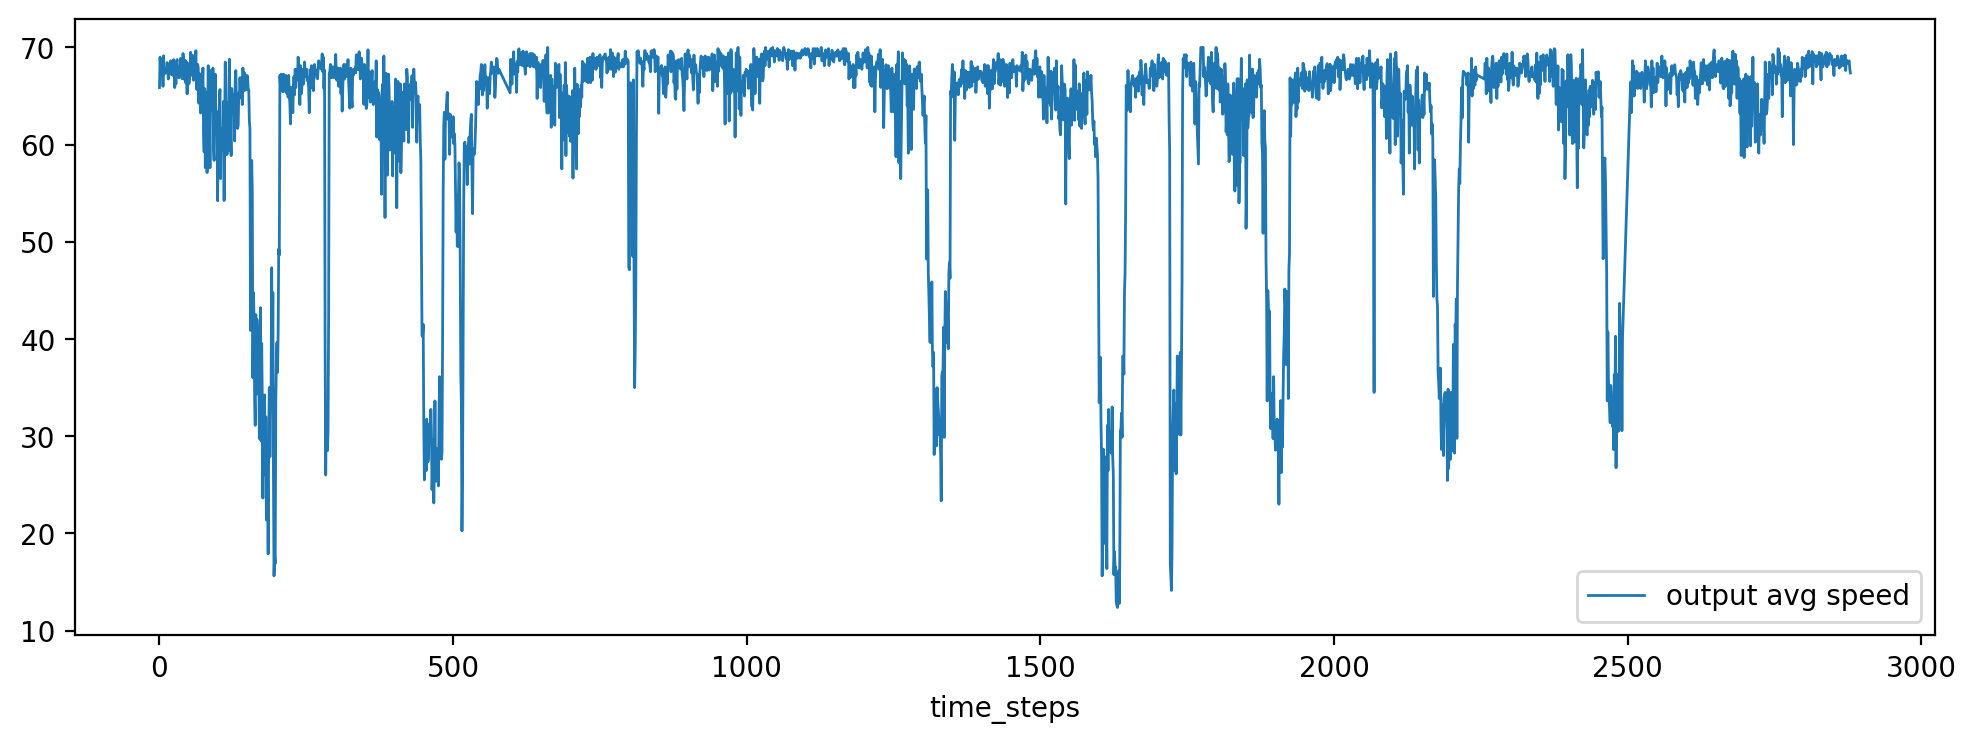

In [ ]:
sensor = 68
offset = 12000
time_steps = 10 * 24 * 60 // 5

fig=plt.figure(figsize=(12,4), dpi= 200)

# plt.plot([b[0,sensor,0] for b in features[offset:offset+time_steps]], label='avg speed', linewidth=1)
plt.plot([b[-1,sensor,0] for b in targets[offset:offset+time_steps]], label='output avg speed', linewidth=1)

plt.xlabel('time_steps')
plt.legend(loc='lower right')

plt.show()

In [ ]:
g = nx.Graph()

for (a, b), w in zip(zip(*edge_index), edge_weight):
  if a != b:
    g.add_edge(a, b, weight=w)

In [ ]:
if ds == 'metrla' and not os.path.exists('graph_sensor_locations_la.csv'):
    !wget https://raw.githubusercontent.com/liyaguang/DCRNN/master/data/sensor_graph/graph_sensor_locations.csv -O graph_sensor_locations_la.csv
if ds == 'pemsbay' and not os.path.exists('graph_sensor_locations_bay.csv'):
    !wget https://raw.githubusercontent.com/liyaguang/DCRNN/master/data/sensor_graph/graph_sensor_locations_bay.csv -O graph_sensor_locations_bay.csv
if ds == 'pemsd7' and not os.path.exists('graph_sensor_locations_d7.csv'):
    !wget https://github.com/VeritasYin/STGCN_IJCAI-18/raw/master/dataset/PeMSD7_M_Station_Info.csv -O graph_sensor_locations_d7.csv

--2023-10-19 02:29:34--  https://raw.githubusercontent.com/liyaguang/DCRNN/master/data/sensor_graph/graph_sensor_locations.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6341 (6.2K) [text/plain]
Saving to: ‘graph_sensor_locations_la.csv’

graph_sensor_locati 100%[===================>]   6.19K  --.-KB/s    in 0s      

2023-10-19 02:29:35 (74.7 MB/s) - ‘graph_sensor_locations_la.csv’ saved [6341/6341]



In [ ]:
import csv

if ds in ['pemsbay', 'metrla', 'pesmd8']:
  locations = []

  with open('graph_sensor_locations_bay.csv' if ds == 'pemsbay' else 'graph_sensor_locations_la.csv' if ds == 'metrla' else 'graph_sensor_locations_d7.csv') as csvfile:
    for i, row in enumerate(csv.reader(csvfile)):
        if ds != 'pemsbay' and i == 0:
          continue

        pos = tuple(-float(x) for x in row[1:2+1][::-1]) if ds == 'pemsbay' else tuple(float(x) for x in row[2:3+1][::-1]) if ds == 'metrla' else tuple(float(x) for x in row[-2:])

        locations.append(pos)
else:
    locations=None

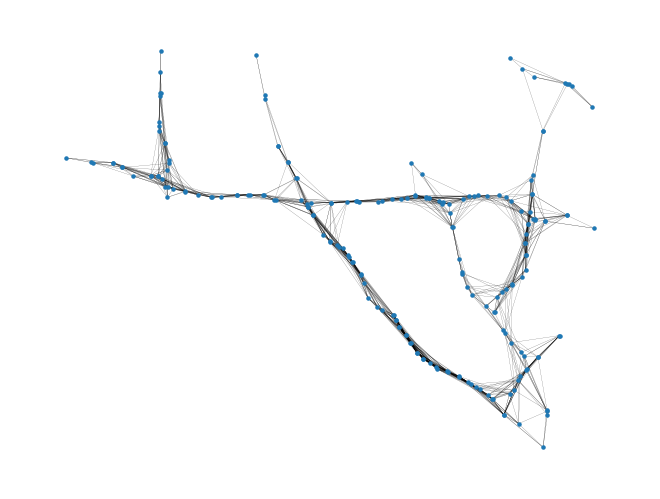

In [ ]:
nx.draw(g, pos=locations, node_size=5, width=0.1)

## Split into train and test

In [ ]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device}")

Using cuda


In [ ]:
from torch.utils.data import Dataset

class DS(Dataset):
  def __init__(self, features, targets):
    self.features = torch.from_numpy(features).to(device)
    self.targets = torch.from_numpy(targets).to(device)

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, i):
    return (self.features[i], self.targets[i])

size = len(features)

test_split = 0.7
val_split = 0.9

test_split_pos = int(size * test_split)
val_split_pos = int(size * val_split)

train_dataset = DS(features[:test_split_pos], targets[:test_split_pos])
test_dataset = DS(features[test_split_pos:val_split_pos], targets[test_split_pos:val_split_pos])
val_dataset = DS(features[val_split_pos:size], targets[val_split_pos:size])

print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

23974
6850
3425


In [ ]:
from torch.utils.data import DataLoader

# class GraphDataLoader(DataLoader):
#   def __init__(self, dataset, edge_index, edge_weight, *args, **kwargs):
#     super().__init__(dataset, *args, **kwargs)
#     self.edge_index = torch.from_numpy(edge_index).to(device)
#     self.edge_weight = torch.from_numpy(edge_weight).to(device)

#   def __iter__(self):
#     res = super().__iter__()
#     return ((x, self.edge_index, self.edge_weight, y) for x, y in res)

batch_size = 32

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

print(len(trainloader))
print([a.shape for a in next(iter(trainloader))])

print(len(testloader))
print([a.shape for a in next(iter(testloader))])


print(len(valloader))
print([a.shape for a in next(iter(valloader))])

750
[torch.Size([32, 12, 207, 1]), torch.Size([32, 12, 207, 1])]
215
[torch.Size([32, 12, 207, 1]), torch.Size([32, 12, 207, 1])]
108
[torch.Size([32, 12, 207, 1]), torch.Size([32, 12, 207, 1])]


## DCRNN layers (from research paper)
<!-- https://github.com/chnsh/DCRNN_PyTorch -->

In [ ]:
import scipy.sparse as sp
from scipy.sparse import linalg
import numpy as np

def calculate_normalized_laplacian(adj):
    """
    # L = D^-1/2 (D-A) D^-1/2 = I - D^-1/2 A D^-1/2
    # D = diag(A 1)
    :param adj:
    :return:
    """
    adj = sp.coo_matrix(adj)
    d = np.array(adj.sum(1))
    d_inv_sqrt = np.power(d, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    normalized_laplacian = sp.eye(adj.shape[0]) - adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()
    return normalized_laplacian


def calculate_random_walk_matrix(adj_mx):
    adj_mx = sp.coo_matrix(adj_mx)
    d = np.array(adj_mx.sum(1))
    d_inv = np.power(d, -1).flatten()
    d_inv[np.isinf(d_inv)] = 0.
    d_mat_inv = sp.diags(d_inv)
    random_walk_mx = d_mat_inv.dot(adj_mx).tocoo()
    return random_walk_mx


def calculate_reverse_random_walk_matrix(adj_mx):
    return calculate_random_walk_matrix(np.transpose(adj_mx))


def calculate_scaled_laplacian(adj_mx, lambda_max=2, undirected=True):
    if undirected:
        adj_mx = np.maximum.reduce([adj_mx, adj_mx.T])
    L = calculate_normalized_laplacian(adj_mx)
    if lambda_max is None:
        lambda_max, _ = linalg.eigsh(L, 1, which='LM')
        lambda_max = lambda_max[0]
    L = sp.csr_matrix(L)
    M, _ = L.shape
    I = sp.identity(M, format='csr', dtype=L.dtype)
    L = (2 / lambda_max * L) - I
    return L.astype(np.float32)


class LayerParams:
    def __init__(self, rnn_network: torch.nn.Module, layer_type: str):
        self._rnn_network = rnn_network
        self._params_dict = {}
        self._biases_dict = {}
        self._type = layer_type

    def get_weights(self, shape):
        if shape not in self._params_dict:
            nn_param = torch.nn.Parameter(torch.empty(*shape, device=device))
            torch.nn.init.xavier_normal_(nn_param)
            self._params_dict[shape] = nn_param
            self._rnn_network.register_parameter('{}_weight_{}'.format(self._type, str(shape)),
                                                 nn_param)
        return self._params_dict[shape]

    def get_biases(self, length, bias_start=0.0):
        if length not in self._biases_dict:
            biases = torch.nn.Parameter(torch.empty(length, device=device))
            torch.nn.init.constant_(biases, bias_start)
            self._biases_dict[length] = biases
            self._rnn_network.register_parameter('{}_biases_{}'.format(self._type, str(length)),
                                                 biases)

        return self._biases_dict[length]


class DCGRUCell(torch.nn.Module):
    def __init__(self, num_units, adj_mx, max_diffusion_step, num_nodes, nonlinearity='tanh',
                 filter_type="laplacian", use_gc_for_ru=True):
        """

        :param num_units:
        :param adj_mx:
        :param max_diffusion_step:
        :param num_nodes:
        :param nonlinearity:
        :param filter_type: "laplacian", "random_walk", "dual_random_walk".
        :param use_gc_for_ru: whether to use Graph convolution to calculate the reset and update gates.
        """

        super().__init__()
        self._activation = torch.tanh if nonlinearity == 'tanh' else torch.nn.functional.elu if nonlinearity == 'elu' else torch.relu
        # support other nonlinearities up here?
        self._num_nodes = num_nodes
        self._num_units = num_units
        self._max_diffusion_step = max_diffusion_step
        self._supports = []
        self._use_gc_for_ru = use_gc_for_ru
        supports = []
        if filter_type == "laplacian":
            supports.append(calculate_scaled_laplacian(adj_mx, lambda_max=None))
        elif filter_type == "random_walk":
            supports.append(calculate_random_walk_matrix(adj_mx).T)
        elif filter_type == "dual_random_walk":
            supports.append(calculate_random_walk_matrix(adj_mx).T)
            supports.append(calculate_random_walk_matrix(adj_mx.T).T)
        else:
            supports.append(calculate_scaled_laplacian(adj_mx))

        for support in supports:
            self._supports.append(self._build_sparse_matrix(support))

        self._fc_params = LayerParams(self, 'fc')
        self._gconv_params = LayerParams(self, 'gconv')

    @staticmethod
    def _build_sparse_matrix(L):
        L = L.tocoo()
        indices = np.column_stack((L.row, L.col))
        # this is to ensure row-major ordering to equal torch.sparse.sparse_reorder(L)
        indices = indices[np.lexsort((indices[:, 0], indices[:, 1]))]
        L = torch.sparse_coo_tensor(indices.T, L.data, L.shape, device=device)
        return L

    def forward(self, inputs, hx):
        """Gated recurrent unit (GRU) with Graph Convolution.
        :param inputs: (B, num_nodes * input_dim)
        :param hx: (B, num_nodes * rnn_units)

        :return
        - Output: A `2-D` tensor with shape `(B, num_nodes * rnn_units)`.
        """
        output_size = 2 * self._num_units
        if self._use_gc_for_ru:
            fn = self._gconv
        else:
            fn = self._fc
        value = torch.sigmoid(fn(inputs, hx, output_size, bias_start=1.0))
        value = torch.reshape(value, (-1, self._num_nodes, output_size))
        r, u = torch.split(tensor=value, split_size_or_sections=self._num_units, dim=-1)
        r = torch.reshape(r, (-1, self._num_nodes * self._num_units))
        u = torch.reshape(u, (-1, self._num_nodes * self._num_units))

        c = self._gconv(inputs, r * hx, self._num_units)
        if self._activation is not None:
            c = self._activation(c)

        new_state = u * hx + (1.0 - u) * c
        return new_state

    @staticmethod
    def _concat(x, x_):
        x_ = x_.unsqueeze(0)
        return torch.cat([x, x_], dim=0)

    def _fc(self, inputs, state, output_size, bias_start=0.0):
        batch_size = inputs.shape[0]
        inputs = torch.reshape(inputs, (batch_size * self._num_nodes, -1))
        state = torch.reshape(state, (batch_size * self._num_nodes, -1))
        inputs_and_state = torch.cat([inputs, state], dim=-1)
        input_size = inputs_and_state.shape[-1]
        weights = self._fc_params.get_weights((input_size, output_size))
        value = torch.sigmoid(torch.matmul(inputs_and_state, weights))
        biases = self._fc_params.get_biases(output_size, bias_start)
        value += biases
        return value

    def _gconv(self, inputs, state, output_size, bias_start=0.0):
        # Reshape input and state to (batch_size, num_nodes, input_dim/state_dim)
        batch_size = inputs.shape[0]
        inputs = torch.reshape(inputs, (batch_size, self._num_nodes, -1))
        state = torch.reshape(state, (batch_size, self._num_nodes, -1))
        inputs_and_state = torch.cat([inputs, state], dim=2)
        input_size = inputs_and_state.size(2)

        x = inputs_and_state
        x0 = x.permute(1, 2, 0)  # (num_nodes, total_arg_size, batch_size)
        x0 = torch.reshape(x0, shape=[self._num_nodes, input_size * batch_size])
        x = torch.unsqueeze(x0, 0)

        if self._max_diffusion_step == 0:
            pass
        else:
            for support in self._supports:
                x1 = torch.sparse.mm(support, x0)
                x = self._concat(x, x1)

                for k in range(2, self._max_diffusion_step + 1):
                    x2 = 2 * torch.sparse.mm(support, x1) - x0
                    x = self._concat(x, x2)
                    x1, x0 = x2, x1

        num_matrices = len(self._supports) * self._max_diffusion_step + 1  # Adds for x itself.
        x = torch.reshape(x, shape=[num_matrices, self._num_nodes, input_size, batch_size])
        x = x.permute(3, 1, 2, 0)  # (batch_size, num_nodes, input_size, order)
        x = torch.reshape(x, shape=[batch_size * self._num_nodes, input_size * num_matrices])

        weights = self._gconv_params.get_weights((input_size * num_matrices, output_size))
        x = torch.matmul(x, weights)  # (batch_size * self._num_nodes, output_size)

        biases = self._gconv_params.get_biases(output_size, bias_start)
        x += biases
        # Reshape res back to 2D: (batch_size, num_node, state_dim) -> (batch_size, num_node * state_dim)
        return torch.reshape(x, [batch_size, self._num_nodes * output_size])

## STGCN layers (from research paper)
<!-- https://github.com/hazdzz/STGCN -->

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from scipy.sparse.linalg import norm

class Align(nn.Module):
    def __init__(self, c_in, c_out):
        super(Align, self).__init__()
        self.c_in = c_in
        self.c_out = c_out
        self.align_conv = nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(1, 1))

    def forward(self, x):
        if self.c_in > self.c_out:
            x = self.align_conv(x)
        elif self.c_in < self.c_out:
            batch_size, _, timestep, n_vertex = x.shape
            x = torch.cat([x, torch.zeros([batch_size, self.c_out - self.c_in, timestep, n_vertex]).to(x)], dim=1)
        else:
            x = x

        return x

class CausalConv1d(nn.Conv1d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, enable_padding=False, dilation=1, groups=1, bias=True):
        if enable_padding == True:
            self.__padding = (kernel_size - 1) * dilation
        else:
            self.__padding = 0
        super(CausalConv1d, self).__init__(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=self.__padding, dilation=dilation, groups=groups, bias=bias)

    def forward(self, input):
        result = super(CausalConv1d, self).forward(input)
        if self.__padding != 0:
            return result[: , : , : -self.__padding]

        return result

class CausalConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, enable_padding=False, dilation=1, groups=1, bias=True):
        kernel_size = nn.modules.utils._pair(kernel_size)
        stride = nn.modules.utils._pair(stride)
        dilation = nn.modules.utils._pair(dilation)
        if enable_padding == True:
            self.__padding = [int((kernel_size[i] - 1) * dilation[i]) for i in range(len(kernel_size))]
        else:
            self.__padding = 0
        self.left_padding = nn.modules.utils._pair(self.__padding)
        super(CausalConv2d, self).__init__(in_channels, out_channels, kernel_size, stride=stride, padding=0, dilation=dilation, groups=groups, bias=bias)

    def forward(self, input):
        if self.__padding != 0:
            input = F.pad(input, (self.left_padding[1], 0, self.left_padding[0], 0))
        result = super(CausalConv2d, self).forward(input)

        return result

class TemporalConvLayer(nn.Module):

    # Temporal Convolution Layer (GLU)
    #
    #        |--------------------------------| * residual connection *
    #        |                                |
    #        |    |--->--- casualconv2d ----- + -------|
    # -------|----|                                   ⊙ ------>
    #             |--->--- casualconv2d --- sigmoid ---|
    #

    #param x: tensor, [bs, c_in, ts, n_vertex]

    def __init__(self, Kt, c_in, c_out, n_vertex, act_func):
        super(TemporalConvLayer, self).__init__()
        self.Kt = Kt
        self.c_in = c_in
        self.c_out = c_out
        self.n_vertex = n_vertex
        self.align = Align(c_in, c_out)
        if act_func == 'glu' or act_func == 'gtu':
            self.causal_conv = CausalConv2d(in_channels=c_in, out_channels=2 * c_out, kernel_size=(Kt, 1), enable_padding=False, dilation=1)
        else:
            self.causal_conv = CausalConv2d(in_channels=c_in, out_channels=c_out, kernel_size=(Kt, 1), enable_padding=False, dilation=1)
        self.act_func = act_func
        self.relu = nn.ReLU()
        self.silu = nn.SiLU()

    def forward(self, x):
        x_in = self.align(x)[:, :, self.Kt - 1:, :]
        x_causal_conv = self.causal_conv(x)

        if self.act_func == 'glu' or self.act_func == 'gtu':
            x_p = x_causal_conv[:, : self.c_out, :, :]
            x_q = x_causal_conv[:, -self.c_out:, :, :]

            if self.act_func == 'glu':
                # Explanation of Gated Linear Units (GLU):
                # The concept of GLU was first introduced in the paper
                # "Language Modeling with Gated Convolutional Networks".
                # URL: https://arxiv.org/abs/1612.08083
                # In the GLU operation, the input tensor X is divided into two tensors, X_a and X_b,
                # along a specific dimension.
                # In PyTorch, GLU is computed as the element-wise multiplication of X_a and sigmoid(X_b).
                # More information can be found here: https://pytorch.org/docs/master/nn.functional.html#torch.nn.functional.glu
                # The provided code snippet, (x_p + x_in) ⊙ sigmoid(x_q), is an example of GLU operation.
                x = torch.mul((x_p + x_in), torch.sigmoid(x_q))

            else:
                # tanh(x_p + x_in) ⊙ sigmoid(x_q)
                x = torch.mul(torch.tanh(x_p + x_in), torch.sigmoid(x_q))

        elif self.act_func == 'relu':
            x = self.relu(x_causal_conv + x_in)

        elif self.act_func == 'silu':
            x = self.silu(x_causal_conv + x_in)

        else:
            raise NotImplementedError(f'ERROR: The activation function {self.act_func} is not implemented.')

        return x

class ChebGraphConv(nn.Module):
    def __init__(self, c_in, c_out, Ks, gso, bias):
        super(ChebGraphConv, self).__init__()
        self.c_in = c_in
        self.c_out = c_out
        self.Ks = Ks
        self.gso = gso
        self.weight = nn.Parameter(torch.FloatTensor(Ks, c_in, c_out))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(c_out))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        #bs, c_in, ts, n_vertex = x.shape
        x = torch.permute(x, (0, 2, 3, 1))

        if self.Ks - 1 < 0:
            raise ValueError(f'ERROR: the graph convolution kernel size Ks has to be a positive integer, but received {self.Ks}.')
        elif self.Ks - 1 == 0:
            x_0 = x
            x_list = [x_0]
        elif self.Ks - 1 == 1:
            x_0 = x
            x_1 = torch.einsum('hi,btij->bthj', self.gso, x)
            x_list = [x_0, x_1]
        elif self.Ks - 1 >= 2:
            x_0 = x
            x_1 = torch.einsum('hi,btij->bthj', self.gso, x)
            x_list = [x_0, x_1]
            for k in range(2, self.Ks):
                x_list.append(torch.einsum('hi,btij->bthj', 2 * self.gso, x_list[k - 1]) - x_list[k - 2])

        x = torch.stack(x_list, dim=2)

        cheb_graph_conv = torch.einsum('btkhi,kij->bthj', x, self.weight)

        if self.bias is not None:
            cheb_graph_conv = torch.add(cheb_graph_conv, self.bias)
        else:
            cheb_graph_conv = cheb_graph_conv

        return cheb_graph_conv

class GraphConv(nn.Module):
    def __init__(self, c_in, c_out, gso, bias):
        super(GraphConv, self).__init__()
        self.c_in = c_in
        self.c_out = c_out
        self.gso = gso
        self.weight = nn.Parameter(torch.FloatTensor(c_in, c_out))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(c_out))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        #bs, c_in, ts, n_vertex = x.shape
        x = torch.permute(x, (0, 2, 3, 1))

        first_mul = torch.einsum('hi,btij->bthj', self.gso, x)
        second_mul = torch.einsum('bthi,ij->bthj', first_mul, self.weight)

        if self.bias is not None:
            graph_conv = torch.add(second_mul, self.bias)
        else:
            graph_conv = second_mul

        return graph_conv

class GraphConvLayer(nn.Module):
    def __init__(self, graph_conv_type, c_in, c_out, Ks, gso, bias):
        super(GraphConvLayer, self).__init__()
        self.graph_conv_type = graph_conv_type
        self.c_in = c_in
        self.c_out = c_out
        self.align = Align(c_in, c_out)
        self.Ks = Ks
        self.gso = gso
        if self.graph_conv_type == 'cheb_graph_conv':
            self.cheb_graph_conv = ChebGraphConv(c_out, c_out, Ks, gso, bias)
        elif self.graph_conv_type == 'graph_conv':
            self.graph_conv = GraphConv(c_out, c_out, gso, bias)

    def forward(self, x):
        x_gc_in = self.align(x)
        if self.graph_conv_type == 'cheb_graph_conv':
            x_gc = self.cheb_graph_conv(x_gc_in)
        elif self.graph_conv_type == 'graph_conv':
            x_gc = self.graph_conv(x_gc_in)
        x_gc = x_gc.permute(0, 3, 1, 2)
        x_gc_out = torch.add(x_gc, x_gc_in)

        return x_gc_out

class STConvBlock(nn.Module):
    # STConv Block contains 'TGTND' structure
    # T: Gated Temporal Convolution Layer (GLU or GTU)
    # G: Graph Convolution Layer (ChebGraphConv or GraphConv)
    # T: Gated Temporal Convolution Layer (GLU or GTU)
    # N: Layer Normolization
    # D: Dropout

    def __init__(self, Kt, Ks, n_vertex, last_block_channel, channels, act_func, graph_conv_type, gso, bias, droprate):
        super(STConvBlock, self).__init__()
        self.tmp_conv1 = TemporalConvLayer(Kt, last_block_channel, channels[0], n_vertex, act_func)
        self.graph_conv = GraphConvLayer(graph_conv_type, channels[0], channels[1], Ks, gso, bias)
        self.tmp_conv2 = TemporalConvLayer(Kt, channels[1], channels[2], n_vertex, act_func)
        self.tc2_ln = nn.LayerNorm([n_vertex, channels[2]])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=droprate)

    def forward(self, x):
        x = self.tmp_conv1(x)
        x = self.graph_conv(x)
        x = self.relu(x)
        x = self.tmp_conv2(x)
        x = self.tc2_ln(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x = self.dropout(x)

        return x

class OutputBlock(nn.Module):
    # Output block contains 'TNFF' structure
    # T: Gated Temporal Convolution Layer (GLU or GTU)
    # N: Layer Normolization
    # F: Fully-Connected Layer
    # F: Fully-Connected Layer

    def __init__(self, Ko, last_block_channel, channels, end_channel, n_vertex, act_func, bias, droprate):
        super(OutputBlock, self).__init__()
        self.tmp_conv1 = TemporalConvLayer(Ko, last_block_channel, channels[0], n_vertex, act_func)
        self.fc1 = nn.Linear(in_features=channels[0], out_features=channels[1], bias=bias)
        self.fc2 = nn.Linear(in_features=channels[1], out_features=end_channel, bias=bias)
        self.tc1_ln = nn.LayerNorm([n_vertex, channels[0]])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=droprate)

    def forward(self, x):
        x = self.tmp_conv1(x)
        x = self.tc1_ln(x.permute(0, 2, 3, 1))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x).permute(0, 3, 1, 2)

        return x

def calc_gso(dir_adj, gso_type):
    n_vertex = dir_adj.shape[0]

    if sp.issparse(dir_adj) == False:
        dir_adj = sp.csc_matrix(dir_adj)
    elif dir_adj.format != 'csc':
        dir_adj = dir_adj.tocsc()

    id = sp.identity(n_vertex, format='csc')

    # Symmetrizing an adjacency matrix
    adj = dir_adj + dir_adj.T.multiply(dir_adj.T > dir_adj) - dir_adj.multiply(dir_adj.T > dir_adj)
    #adj = 0.5 * (dir_adj + dir_adj.transpose())

    if gso_type == 'sym_renorm_adj' or gso_type == 'rw_renorm_adj' \
        or gso_type == 'sym_renorm_lap' or gso_type == 'rw_renorm_lap':
        adj = adj + id

    if gso_type == 'sym_norm_adj' or gso_type == 'sym_renorm_adj' \
        or gso_type == 'sym_norm_lap' or gso_type == 'sym_renorm_lap':
        row_sum = adj.sum(axis=1).A1
        row_sum_inv_sqrt = np.power(row_sum, -0.5)
        row_sum_inv_sqrt[np.isinf(row_sum_inv_sqrt)] = 0.
        deg_inv_sqrt = sp.diags(row_sum_inv_sqrt, format='csc')
        # A_{sym} = D^{-0.5} * A * D^{-0.5}
        sym_norm_adj = deg_inv_sqrt.dot(adj).dot(deg_inv_sqrt)

        if gso_type == 'sym_norm_lap' or gso_type == 'sym_renorm_lap':
            sym_norm_lap = id - sym_norm_adj
            gso = sym_norm_lap
        else:
            gso = sym_norm_adj

    elif gso_type == 'rw_norm_adj' or gso_type == 'rw_renorm_adj' \
        or gso_type == 'rw_norm_lap' or gso_type == 'rw_renorm_lap':
        row_sum = np.sum(adj, axis=1).A1
        row_sum_inv = np.power(row_sum, -1)
        row_sum_inv[np.isinf(row_sum_inv)] = 0.
        deg_inv = np.diag(row_sum_inv)
        # A_{rw} = D^{-1} * A
        rw_norm_adj = deg_inv.dot(adj)

        if gso_type == 'rw_norm_lap' or gso_type == 'rw_renorm_lap':
            rw_norm_lap = id - rw_norm_adj
            gso = rw_norm_lap
        else:
            gso = rw_norm_adj

    else:
        raise ValueError(f'{gso_type} is not defined.')

    return gso

def calc_chebynet_gso(gso):
    if sp.issparse(gso) == False:
        gso = sp.csc_matrix(gso)
    elif gso.format != 'csc':
        gso = gso.tocsc()

    id = sp.identity(gso.shape[0], format='csc')
    # If you encounter a NotImplementedError, please update your scipy version to 1.10.1 or later.
    eigval_max = norm(gso, 2)

    # If the gso is symmetric or random walk normalized Laplacian,
    # then the maximum eigenvalue is smaller than or equals to 2.
    if eigval_max >= 2:
        gso = gso - id
    else:
        gso = 2 * gso / eigval_max - id

    return gso

def mat_to_gso(matrix, gso_type, graph_conv_type):
    gso = calc_gso(matrix, gso_type)
    if graph_conv_type == 'cheb_graph_conv':
        gso = calc_chebynet_gso(gso)
    gso = gso.toarray()
    gso = gso.astype(dtype=np.float32)

    return torch.from_numpy(gso).to(device)

In [ ]:
# from torch import nn
# from torch_geometric.nn import GCN
# # from torch_geometric_temporal.nn import STConv

# class Model(nn.Module):
#   def __init__(self, num_nodes, in_features, in_timesteps, out_features, out_timesteps, matrix):
#     super().__init__()
#     self.num_nodes = num_nodes
#     self.in_features = in_features
#     self.in_timesteps = in_timesteps
#     self.out_features = out_features
#     self.out_timesteps = out_timesteps

#     # self.lstm = nn.LSTM(input_size=num_nodes * in_features, hidden_size=num_nodes, num_layers=1, batch_first=True)
#     # self.linear = nn.Linear(1, 1)

#     self.gcn1 = GCN(in_features, 2, 3, 2)
#     self.lstm1 = nn.LSTM(input_size=num_nodes * 2, hidden_size=num_nodes*3, batch_first=True)
#     self.linear1 = nn.Linear(3, 2)
#     self.linear2 = nn.Linear(2, 1)

#     # self.linear = nn.Linear(1, 1)

#   def forward(self, x, e, w):
#     # x.shape : [batch_size, timesteps, nodes, features]

#     batches, timesteps, nodes, features = x.shape

#     x = self.gcn1(x, e, edge_weight=w)
#     x = torch.reshape(x, (batches, timesteps, nodes*2))
#     x, _ = self.lstm1(x)
#     x = torch.reshape(x, (batches, timesteps, nodes, 3))
#     x = self.linear1(x)
#     x = self.linear2(x)
#     return x[:,-1,:,:]


In [ ]:
# from torch import nn
# # from torch_geometric.nn import GCN

# class Model(nn.Module):
#   def __init__(self, num_nodes, in_features, in_timesteps, out_features, out_timesteps, matrix):
#     super().__init__()
#     self.num_nodes = num_nodes
#     self.in_features = in_features
#     self.in_timesteps = in_timesteps
#     self.out_features = out_features
#     self.out_timesteps = out_timesteps

#     self.hidden_channels = 2

#     self.dccell1 = DCGRUCell(self.hidden_channels, matrix, 2, num_nodes, filter_type='dual_random_walk', nonlinearity='tanh')
#     self.drop1 = nn.Dropout(0.3)
#     self.dccell2 = DCGRUCell(self.hidden_channels, matrix, 2, num_nodes, filter_type='dual_random_walk', nonlinearity='tanh')
#     self.drop2 = nn.Dropout(0.3)
#     self.dccell3 = DCGRUCell(self.hidden_channels, matrix, 2, num_nodes, filter_type='dual_random_walk', nonlinearity='tanh')
#     self.drop3 = nn.Dropout(0.3)
#     self.dccell4 = DCGRUCell(self.hidden_channels, matrix, 2, num_nodes, filter_type='dual_random_walk', nonlinearity='tanh')

#     self.linear3 = nn.Linear(self.hidden_channels, 3)
#     self.elu = nn.ELU()
#     self.linear4 = nn.Linear(3, out_features)

#   def forward_single(self, x, hs=None):
#     # x.shape = [batch_size, nodes * channels]

#     batches, nc = x.shape
#     nodes = nc//self.hidden_channels

#     if hs == None:
#       hs = [torch.zeros(batches, nodes*self.hidden_channels, device=device) for _ in range(4)]

#     for t in range(timesteps):
#       # print(x.shape)
#       # print(hs[0].shape)
#       hs[0] = self.dccell1(x, hs[0])
#       hs[0] = self.drop1(hs[0])

#       hs[1] = self.dccell2(hs[0], hs[1])
#       hs[1] = self.drop1(hs[1])

#       # h = self.gcn1(h1.reshape(batches, nodes, self.gcn_channels), e, edge_weight=w).reshape(batches, nodes*self.gcn_channels)
#       hs[2] = self.dccell3(hs[1], hs[2])
#       hs[2] = self.drop1(hs[2])

#       hs[3] = self.dccell4(hs[2], hs[3])

#     return hs

#   def forward(self, x, e, w):
#     # x.shape : [batch_size, timesteps, nodes, features]

#     batches, timesteps, nodes, features = x.shape

#     # x = x.reshape(batches, timesteps, nodes, 2)

#     # x = torch.permute(x, (0, 3, 1, 2))
#     # x = self.stconv1(x)
#     # # print(x.shape)
#     # x = torch.permute(x, (0, 2, 3, 1))
#     # # print(x.shape)
#     # # return x[:,-1,:,:]

#     # # x = self.linear2(x)

#     # timesteps = x.shape[1]
#     x = torch.reshape(x, (batches, timesteps, nodes*self.hidden_channels))
#     # print(x.shape)

#     hs = None
#     for t in range(timesteps):
#       hs = self.forward_single(x[:,t,:], hs)

#     out = [hs[-1]]

#     # print(out[-1].shape)
#     for t in range(self.out_timesteps-1):
#         hs = self.forward_single(out[-1], hs)
#         out.append(hs[-1])

#     x = torch.stack(out, dim=1)

#     x = x.reshape(batches, self.out_timesteps, nodes, self.hidden_channels)
#     # print(x.shape)

#     x = self.linear3(x)
#     x = self.elu(x)
#     x = self.linear4(x)

#     return x


## Create model

In [ ]:
from torch import nn

class Model(nn.Module):
  def __init__(self, num_nodes, in_features, in_timesteps, out_features, out_timesteps, matrix):
    super().__init__()
    self.num_nodes = num_nodes
    self.in_features = in_features
    self.in_timesteps = in_timesteps
    self.out_features = out_features
    self.out_timesteps = out_timesteps

    gso_type = 'sym_norm_lap'
    graph_conv_type = 'cheb_graph_conv'
    gso = mat_to_gso(matrix, gso_type, graph_conv_type)

    self.stconv1 = STConvBlock(3, 3, num_nodes, in_features, [64, 16, 64], 'glu', graph_conv_type, gso, True, 0.5)
    self.stconv2 = STConvBlock(3, 3, num_nodes, 64, [64, 16, 64], 'glu', graph_conv_type, gso, True, 0.5)
    # self.stconv3 = STConvBlock(2, 3, num_nodes, 32, [32, 16, 16], 'glu', graph_conv_type, gso, True, 0.5)

    # K = 3
    # L_tilde = scaled_Laplacian(matrix)
    # cheb_polynomials = [torch.from_numpy(i).type(torch.FloatTensor).to(device) for i in cheb_polynomial(L_tilde, K)]

    # self.astconv1 = ASTGCN_block(device, in_features, K, 16, 64, 1, cheb_polynomials, self.num_nodes, self.in_timesteps)
    # self.astconv2 = ASTGCN_block(device, 64, K, 16, 64, 1, cheb_polynomials, self.num_nodes, self.in_timesteps)

    self.hidden_channels = 4

    self.linear1 = nn.Linear(64, self.hidden_channels)

    self.dccell0 = DCGRUCell(self.hidden_channels * 4, matrix, 2, num_nodes, filter_type='dual_random_walk', nonlinearity='tanh')
    self.dccell1 = DCGRUCell(self.hidden_channels * 4, matrix, 2, num_nodes, filter_type='dual_random_walk', nonlinearity='tanh')
    self.dccell2 = DCGRUCell(self.hidden_channels * 4, matrix, 2, num_nodes, filter_type='dual_random_walk', nonlinearity='tanh')

    self.linear3 = nn.Linear(self.hidden_channels, 3)
    self.elu = nn.ELU()
    self.linear4 = nn.Linear(3, out_features)

  def forward_single(self, x, hs=None):
    # x.shape : [batch_size, timesteps, nodes, features]

    batches, timesteps, nodes, features = x.shape

    if hs == None:
      hs = [torch.zeros(batches, nodes*self.hidden_channels*4, device=device) for _ in range(3)]

    x = torch.permute(x, (0, 3, 1, 2))
    x = self.stconv1(x)
    x = self.stconv2(x)
    # x = self.stconv3(x)
    x = torch.permute(x, (0, 2, 3, 1))

    x = self.linear1(x)

    # print(x.shape)

    timesteps = x.shape[1]
    x = torch.reshape(x, (batches, timesteps * nodes * self.hidden_channels))

    hs[0] = self.dccell1(x, hs[0])
    hs[1] = self.dccell1(hs[0], hs[1])
    hs[2] = self.dccell2(hs[1], hs[2])

    x = hs[2]

    # print(x.shape)

    x = torch.reshape(x, (batches, timesteps, nodes, self.hidden_channels))

    x = x[:,-4:,:,:]

    x = self.linear3(x)
    x = self.elu(x)
    x = self.linear4(x)

    return x, hs

  def forward(self, x, out_timesteps):
    # print('x', x.shape)

    out = []

    hs = None
    for _ in range(0, out_timesteps, 4):
      next_x, hs = self.forward_single(x, hs)

      # print('next x', next_x.shape)
      out.append(next_x)

      x = torch.cat((x[:,-8:,:,:], next_x), dim=1)

    return torch.cat(out, dim=1)


In [ ]:
num_nodes = features.shape[-2]
num_node_features_in = features.shape[-1]
num_node_features_out = targets.shape[-1]

in_timesteps = timesteps
out_timesteps = pred_offset

adj_matrix = mat

model = Model(num_nodes, num_node_features_in, in_timesteps, num_node_features_out, out_timesteps, adj_matrix).to(device)
model

/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[4.10952606e-06]
not reaching the requested tolerance 3.084540367126465e-06.
Use iteration 21 instead with accuracy 
4.1095260569918365e-06.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[4.10952606e-06]
not reaching the requested tolerance 3.084540367126465e-06.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Model(
  (stconv1): STConvBlock(
    (tmp_conv1): TemporalConvLayer(
      (align): Align(
        (align_conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (causal_conv): CausalConv2d(1, 128, kernel_size=(3, 1), stride=(1, 1))
      (relu): ReLU()
      (silu): SiLU()
    )
    (graph_conv): GraphConvLayer(
      (align): Align(
        (align_conv): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (cheb_graph_conv): ChebGraphConv()
    )
    (tmp_conv2): TemporalConvLayer(
      (align): Align(
        (align_conv): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (causal_conv): CausalConv2d(16, 128, kernel_size=(3, 1), stride=(1, 1))
      (relu): ReLU()
      (silu): SiLU()
    )
    (tc2_ln): LayerNorm((207, 64), eps=1e-05, elementwise_affine=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (stconv2): STConvBlock(
    (tmp_conv1): TemporalConvLayer(
      (align): Align(
        (align_conv): Conv2d(64, 64

In [ ]:
x, y = next(iter(trainloader))

print('input shape:', x.shape)
print('expected shape:', y.shape)
print('output shape:', model(x, out_timesteps).shape)

input shape: torch.Size([32, 12, 207, 1])
expected shape: torch.Size([32, 12, 207, 1])
output shape: torch.Size([32, 12, 207, 1])


## loss fn, optimizer & train loop

In [ ]:
from torch import nn, optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)
# optimizer = optim.RMSprop(model.parameters(), lr=0.002)

In [ ]:
from contextlib import nullcontext

from tqdm.auto import tqdm

def mae_loss(pred, y):
  pred = pred.detach()
  y = y.detach()
  return torch.mean(torch.abs(pred - y))

def mape_loss(pred, y):
  pred = pred.detach()
  y = y.detach()
  return torch.mean(100 * torch.abs(pred.detach() - y) / y)

def forward_one_epoch(dataloader, model, loss_fn, device, train=False, optimizer=None):
    # print('Training...' if train else 'Testing...')

    batch_count = len(dataloader)
    size = len(dataloader.dataset)

    total_loss = 0
    loss_per_timestep = np.zeros((out_timesteps,))

    total_mae = 0
    mae_per_timestep = np.zeros((out_timesteps,))

    total_mape = 0
    mape_per_timestep = np.zeros((out_timesteps,))

    if train:
      model.train()
    else:
      model.eval()

    with torch.no_grad() if not train else nullcontext():
      with tqdm(total=batch_count, bar_format=('Training' if train else 'Testing') + "  |{bar}|  [{postfix[0][value]:>4d}/{total}]  loss: {postfix[1][loss]:>.2f}  {elapsed}", postfix=[{"value": 0}, {"loss": 0}]) as t:
          for i, (x, y) in enumerate(dataloader):
              x, y = x.to(device), y.to(device)

              batch_size = x.shape[0]

              # Compute prediction error
              # pred = model(x, e, w)
              pred = model(x, y.shape[1])
              loss = loss_fn(pred, y)

              # Backpropagation
              if train:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

              total_loss += loss.item() * batch_size
              loss_per_timestep += np.array([loss_fn(pred[:,t,:,:], y[:,t,:,:]).detach().to('cpu') for t in range(out_timesteps)]) * batch_size

              total_mae += mae_loss(pred, y) * batch_size
              mae_per_timestep += np.array([mae_loss(pred[:,t,:,:], y[:,t,:,:]).detach().to('cpu') for t in range(out_timesteps)]) * batch_size

              total_mape += mape_loss(pred, y) * batch_size
              mape_per_timestep += np.array([mape_loss(pred[:,t,:,:], y[:,t,:,:]).detach().to('cpu') for t in range(out_timesteps)]) * batch_size

              t.postfix[0]["value"] = i+1
              t.postfix[1]["loss"] = loss.item()
              t.update()

    avg_loss = total_loss / size
    avg_loss_per_timestep = loss_per_timestep / size
    print(f'Avg loss (MSE): {avg_loss:>7f}')
    print(f'loss per timestep: {avg_loss_per_timestep}')

    print()

    print(f'RMSE: {avg_loss ** 0.5:>7f}')
    print(f'RMSE per timestep: {avg_loss_per_timestep ** 0.5}')

    print()

    avg_mae = total_mae / size
    avg_mae_per_timestep = mae_per_timestep / size
    print(f'Avg MAE: {avg_mae:>7f}')
    print(f'Avg MAE per timestep: {avg_mae_per_timestep}')

    print()

    avg_mape = total_mape / size
    avg_mape_per_timestep = mape_per_timestep / size
    print(f'Avg MAPE: {avg_mape:>7f}')
    print(f'Avg MAPE per timestep: {avg_mape_per_timestep}')

    return avg_loss

## Train and Test

In [ ]:
train_history = []
test_history = []
epochs = 0

# loss before training
train_loss = forward_one_epoch(trainloader, model, loss_fn, device, train=False, optimizer=None)
train_history.append(train_loss)

test_loss = forward_one_epoch(testloader, model, loss_fn, device, train=False, optimizer=None)
test_history.append(test_loss)

Testing  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 3619.380643
loss per timestep: [3619.4996883  3619.49626817 3619.48210048 3619.47312339 3619.40946369
 3619.39996202 3619.38860295 3619.36321868 3619.30799382 3619.26087474
 3619.26336409 3619.2219254 ]

RMSE: 60.161289
RMSE per timestep: [60.16227795 60.16224953 60.16213178 60.16205717 60.1615281  60.16144913
 60.16135473 60.16114376 60.16068479 60.16029317 60.16031386 60.15996946]

Avg MAE: 58.771030
Avg MAE per timestep: [58.77258384 58.77251191 58.77228463 58.77216457 58.77152991 58.77140831
 58.77110139 58.77084087 58.77012842 58.76968597 58.76936316 58.76896265]

Avg MAPE: 100.622963
Avg MAPE per timestep: [100.62310211 100.62325443 100.62305306 100.62328379 100.62251955
 100.62291325 100.62253864 100.62310396 100.62248411 100.62306095
 100.62278576 100.6235533 ]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 3592.998196
loss per timestep: [3592.38047067 3592.45469748 3592.54723811 3592.63790859 3592.69819814
 3592.81194101 3592.95118093 3593.12210524 3593.28360687 3593.4654381
 3593.70688883 3593.91748303]

RMSE: 59.941623
RMSE per timestep: [59.93647029 59.9370895  59.93786147 59.93861784 59.93912077 59.94006958
 59.94123106 59.94265681 59.94400393 59.94552058 59.94753447 59.94929093]

Avg MAE: 58.405632
Avg MAE per timestep: [58.39873611 58.39956524 58.40054639 58.40159613 58.40234928 58.40366937
 58.4050679  58.40698639 58.40875798 58.41095354 58.4134258  58.41597416]

Avg MAPE: 100.638809
Avg MAPE per timestep: [100.63923387 100.63933506 100.63910738 100.63928899 100.63850141
 100.63879303 100.63837569 100.63888347 100.63821497 100.63865557
 100.63831465 100.63901884]


In [ ]:
for i in range(40):
  epochs += 1
  print('Epoch', epochs)

  train_loss = forward_one_epoch(trainloader, model, loss_fn, device, train=True, optimizer=optimizer)
  train_history.append(train_loss)

  test_loss = forward_one_epoch(testloader, model, loss_fn, device, train=False, optimizer=None)
  test_history.append(test_loss)
  print()

  if epochs % 5 == 0:
    torch.save(model.state_dict(), f'model_{epochs}ep.pt')

Epoch 1


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 2406.262988
loss per timestep: [2407.21778238 2407.72091633 2407.07488339 2407.90445735 2405.94652756
 2405.89424391 2405.77849144 2405.82780575 2405.42117323 2405.42477316
 2405.41872282 2405.5253472 ]

RMSE: 49.053675
RMSE per timestep: [49.06340574 49.06853285 49.06194945 49.07040307 49.0504488  49.04991584
 49.04873588 49.04923858 49.04509326 49.04512996 49.04506828 49.04615527]

Avg MAE: 46.693485
Avg MAE per timestep: [46.70062559 46.70560139 46.70005053 46.70898971 46.69061564 46.69063415
 46.68984907 46.68958253 46.68680405 46.68690926 46.68640001 46.68580617]

Avg MAPE: 78.591972
Avg MAPE per timestep: [78.59658977 78.60889024 78.59745767 78.62152757 78.58568149 78.58895702
 78.58354752 78.5837606  78.58298189 78.58744336 78.58580595 78.58140034]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 1003.226450
loss per timestep: [1003.00937742 1003.16115366 1003.05685066 1003.32596822 1003.09519517
 1003.12972043 1003.17222239 1003.23034379 1003.28823485 1003.35152436
 1003.41522368 1003.48143491]

RMSE: 31.673750
RMSE per timestep: [31.67032329 31.67271939 31.67107277 31.67532112 31.67167812 31.67222317
 31.67289413 31.67381164 31.67472549 31.67572453 31.67673    31.67777509]

Avg MAE: 30.011869
Avg MAE per timestep: [30.00726109 30.00969082 30.00834616 30.01223616 30.00937274 30.010142
 30.01102862 30.0122386  30.01350397 30.01485599 30.01620831 30.01757517]

Avg MAPE: 52.016838
Avg MAPE per timestep: [52.01934327 52.02175487 52.01893051 52.02044548 52.01734953 52.01654385
 52.01605821 52.01568031 52.01504348 52.01445914 52.01389003 52.01262803]

Epoch 2


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 391.058867
loss per timestep: [390.9585943  391.03270567 391.07023714 391.11461443 391.0929568
 391.11568118 391.14340412 391.13395516 391.08976311 390.97597413
 391.02820087 390.95019726]

RMSE: 19.775208
RMSE per timestep: [19.77267292 19.77454691 19.77549588 19.77661787 19.77607031 19.77664484
 19.77734573 19.77710685 19.77598956 19.7731124  19.77443301 19.77246058]

Avg MAE: 17.378098
Avg MAE per timestep: [17.3740692  17.37641816 17.37690145 17.37915657 17.37873568 17.37915921
 17.38031533 17.38016199 17.37866794 17.37804256 17.37847408 17.37711974]

Avg MAPE: 35.625843
Avg MAPE per timestep: [35.61486696 35.61823116 35.62193641 35.62334804 35.62316944 35.62573798
 35.63166904 35.63250751 35.63127173 35.62842093 35.62954992 35.6293669 ]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 185.658479
loss per timestep: [185.85878679 185.84243006 185.8199699  185.34221451 185.7671667
 185.737121   185.70702645 185.66868977 185.62197545 185.57017471
 185.51380041 185.45233029]

RMSE: 13.625655
RMSE per timestep: [13.63300359 13.63240368 13.63157988 13.61404475 13.62964294 13.62854068
 13.62743653 13.62602986 13.6243156  13.62241442 13.62034509 13.61808835]

Avg MAE: 10.564020
Avg MAE per timestep: [10.5668218  10.56757804 10.56592684 10.57355324 10.56462156 10.56400031
 10.56340783 10.5626444  10.56163587 10.56055815 10.55937818 10.5581221 ]

Avg MAPE: 30.424545
Avg MAPE per timestep: [30.45891193 30.45641005 30.45182269 30.40199922 30.44162469 30.43554926
 30.42966061 30.42237247 30.4135947  30.40433321 30.39477369 30.38359693]

Epoch 3


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 76.583594
loss per timestep: [66.95492785 68.3796736  68.92578156 69.04356295 70.25156583 73.59305184
 77.30781016 79.59924103 81.85386161 84.82336543 87.99441104 90.27586078]

RMSE: 8.751205
RMSE per timestep: [8.18259909 8.2692003  8.30215524 8.30924563 8.38162072 8.57863928
 8.79248601 8.92184068 9.0473124  9.20996012 9.38053362 9.501361  ]

Avg MAE: 6.193300
Avg MAE per timestep: [5.908072   5.95347554 5.9589181  5.98579921 5.98810865 6.08628223
 6.21947166 6.30012541 6.33215677 6.42471213 6.53999267 6.62246746]

Avg MAPE: 15.520671
Avg MAPE per timestep: [14.27229391 14.42710215 14.57011959 14.47422347 14.94943108 15.32512213
 15.71962903 15.89312332 16.16441624 16.51419725 16.8522061  17.08626667]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 47.821512
loss per timestep: [36.63640899 37.1543749  37.02883194 37.46041496 41.79185315 44.77737781
 48.16371274 51.37350893 56.02796602 58.42642402 61.01084255 64.00641627]

RMSE: 6.915310
RMSE per timestep: [6.05280175 6.09543886 6.08513204 6.1204914  6.46466187 6.69159008
 6.94000812 7.16753158 7.4851831  7.64371795 7.81094377 8.00040101]

Avg MAE: 4.333113
Avg MAE per timestep: [3.95665414 3.98232963 3.96342139 3.98988409 4.11583146 4.22463367
 4.36986308 4.48185084 4.56085738 4.66518693 4.79112721 4.89571673]

Avg MAPE: 11.827247
Avg MAPE per timestep: [10.20111091 10.32691943 10.26574832 10.32529021 11.21514534 11.64656062
 12.0092395  12.32781511 12.85215384 13.24531707 13.57878663 13.93286351]

Epoch 4


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 45.333177
loss per timestep: [35.13224388 35.43486443 35.5594488  35.86461444 39.73957789 42.57269226
 45.89199861 48.81713719 52.50613743 54.87142624 57.43111345 60.17685797]

RMSE: 6.732992
RMSE per timestep: [5.92724589 5.95271908 5.96317439 5.98870724 6.30393353 6.52477527
 6.77436334 6.98692616 7.24611188 7.40752497 7.57833184 7.75737442]

Avg MAE: 4.095427
Avg MAE per timestep: [3.72706116 3.74724078 3.73861892 3.76625976 3.86224157 3.97525923
 4.13840829 4.25768621 4.3013799  4.40753266 4.55424937 4.66920097]

Avg MAPE: 10.838036
Avg MAPE per timestep: [ 9.42428105  9.50066557  9.47685703  9.51784872 10.21172025 10.57695085
 11.0131081  11.36537371 11.67992799 12.01836962 12.42968151 12.8416352 ]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 42.193092
loss per timestep: [31.98967493 32.32812299 32.34145688 32.46602667 36.87858691 39.80949868
 42.86082295 45.70938818 49.39750505 51.88181008 54.02653947 56.62765426]

RMSE: 6.495621
RMSE per timestep: [5.65594156 5.68578253 5.68695497 5.69789669 6.07277423 6.30947689
 6.54681777 6.76087185 7.02833587 7.20290289 7.35027479 7.52513483]

Avg MAE: 3.802670
Avg MAE per timestep: [3.40911051 3.42075922 3.41460729 3.42839196 3.59581394 3.70562693
 3.85691759 3.97257308 4.03128813 4.14230656 4.27700426 4.3776444 ]

Avg MAPE: 10.755147
Avg MAPE per timestep: [ 9.13409187  9.24822044  9.17880997  9.22162456 10.10620137 10.53801381
 11.02853677 11.42718494 11.61611222 12.06130713 12.52715183 12.97447861]

Epoch 5


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 42.232483
loss per timestep: [32.82483281 33.07575452 33.21549633 33.34118552 37.0702608  39.74065958
 42.79776222 45.48721618 48.81340654 51.04821356 53.44532777 55.92967045]

RMSE: 6.498652
RMSE per timestep: [5.72929601 5.75115245 5.76328867 5.77418267 6.08853519 6.30401932
 6.54199986 6.74442112 6.98665918 7.14480326 7.31063115 7.47861421]

Avg MAE: 3.820516
Avg MAE per timestep: [3.46213285 3.47758432 3.47125382 3.48868118 3.59593935 3.70237277
 3.85678656 3.98049148 4.02404185 4.12621084 4.27163769 4.38905727]

Avg MAPE: 10.216691
Avg MAPE per timestep: [ 8.88325643  8.9523461   8.91904185  8.94639665  9.60271283  9.9459012
 10.37837815 10.74171107 10.99748241 11.32704301 11.7496845  12.15637533]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 40.084060
loss per timestep: [30.67793193 30.97015595 30.95809673 31.05441635 35.26017367 37.90109945
 40.765094   43.3970812  46.67927278 48.91228994 50.94689231 53.48620316]

RMSE: 6.331197
RMSE per timestep: [5.53876628 5.56508364 5.56400007 5.57264895 5.93802776 6.15638688
 6.38475481 6.5876461  6.83222312 6.99373219 7.13770918 7.31342623]

Avg MAE: 3.611806
Avg MAE per timestep: [3.25505282 3.26834043 3.2567612  3.27028413 3.42162463 3.51625175
 3.64719819 3.76422884 3.82993918 3.92228478 4.03964151 4.15005417]

Avg MAPE: 10.226007
Avg MAPE per timestep: [ 8.73400532  8.81167383  8.73987825  8.76431171  9.64005068 10.00286269
 10.46496041 10.86596512 11.05225331 11.42908608 11.87773998 12.32930133]

Epoch 6


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 40.553496
loss per timestep: [31.84939728 32.01722409 32.13375143 32.2352872  35.73327491 38.2670197
 41.13094784 43.6273909  46.64806218 48.68009593 50.97987652 53.33961009]

RMSE: 6.368163
RMSE per timestep: [5.64352703 5.65837645 5.66866399 5.67761281 5.97773159 6.18603425
 6.41334139 6.6051034  6.82993867 6.97711229 7.14001936 7.30339716]

Avg MAE: 3.705851
Avg MAE per timestep: [3.36552622 3.37934743 3.37273528 3.38550101 3.48765217 3.59229491
 3.73745084 3.8588274  3.89712522 3.99807774 4.13875475 4.25689315]

Avg MAPE: 9.908682
Avg MAPE per timestep: [ 8.6546788   8.70740002  8.67755361  8.70196236  9.31435516  9.64089325
 10.05978903 10.41899411 10.64333181 10.94843903 11.36645497 11.77032379]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 39.129244
loss per timestep: [30.23667224 30.34067619 30.43411104 30.46349243 34.62404128 37.05008383
 39.87024158 42.16953077 45.47775416 47.49634543 49.61064726 51.77732052]

RMSE: 6.255337
RMSE per timestep: [5.49878825 5.50823712 5.51671198 5.51937428 5.88421968 6.086878
 6.31428868 6.49380711 6.74371961 6.89175924 7.04348261 7.19564594]

Avg MAE: 3.626866
Avg MAE per timestep: [3.2709039  3.27710996 3.27095221 3.27570516 3.4452602  3.54550128
 3.68203787 3.77967301 3.83246914 3.93459144 4.06051631 4.14768193]

Avg MAPE: 10.212926
Avg MAPE per timestep: [ 8.66498943  8.71218797  8.68860567  8.67186602  9.66074003 10.00332438
 10.47583938 10.77892195 11.13936074 11.49936068 11.96562361 12.29425663]

Epoch 7


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 39.449941
loss per timestep: [31.16647887 31.30613301 31.4202918  31.42926673 34.82910194 37.29627487
 40.00919302 42.3881803  45.32406592 47.19079885 49.36191367 51.67758542]

RMSE: 6.280919
RMSE per timestep: [5.58269459 5.59518838 5.60538061 5.60618112 5.90161859 6.10706762
 6.32528205 6.51062058 6.73231505 6.86955594 7.02580342 7.18871236]

Avg MAE: 3.634569
Avg MAE per timestep: [3.3077335  3.31727852 3.31287453 3.32005232 3.42017503 3.52452459
 3.65965696 3.78031901 3.82272824 3.92118088 4.05320954 4.17509575]

Avg MAPE: 9.709205
Avg MAPE per timestep: [ 8.50049752  8.5403441   8.52187173  8.5333855   9.12332791  9.44528075
  9.84753378 10.20055262 10.43229094 10.71831899 11.12448954 11.52257577]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 38.500379
loss per timestep: [29.81966676 29.98755823 30.02959847 30.08075733 34.30224013 36.69131986
 39.12585956 41.46151054 44.7568269  46.50286565 48.36880384 50.87752519]

RMSE: 6.204867
RMSE per timestep: [5.46073866 5.47608968 5.47992687 5.48459272 5.85681143 6.05733604
 6.25506671 6.43906131 6.69005433 6.81930096 6.95476842 7.13284832]

Avg MAE: 3.486035
Avg MAE per timestep: [3.16224418 3.16535988 3.16022743 3.16931728 3.31712818 3.40302767
 3.50782316 3.60668635 3.70604705 3.77706147 3.88014528 3.97736356]

Avg MAPE: 10.002178
Avg MAPE per timestep: [ 8.72793557  8.76163434  8.70423137  8.72714441  9.48091854  9.79260742
 10.1224154  10.49921321 10.8233606  11.09616237 11.42955345 11.86099002]

Epoch 8


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 38.811507
loss per timestep: [30.77708125 30.90926934 31.0074236  31.02352472 34.3256523  36.77294118
 39.34042105 41.66773239 44.53772309 46.30510327 48.40735798 50.66384317]

RMSE: 6.229888
RMSE per timestep: [5.54770955 5.55961054 5.56843098 5.56987654 5.8588098  6.06406969
 6.27219428 6.45505479 6.6736589  6.80478532 6.95753965 7.11785383]

Avg MAE: 3.597228
Avg MAE per timestep: [3.27941111 3.28641994 3.28266005 3.28948212 3.38731323 3.49161674
 3.62124405 3.73960867 3.78045487 3.87760646 4.00514763 4.12575145]

Avg MAPE: 9.597844
Avg MAPE per timestep: [ 8.42079717  8.45434214  8.44048415  8.45218598  9.02087654  9.33960531
  9.72841059 10.07705881 10.31092028 10.5853307  10.98076518 11.36340423]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 37.577685
loss per timestep: [29.49517687 29.54556715 29.62705429 29.7323009  33.81777769 36.01204192
 38.47791458 40.47441968 43.32541381 44.89472847 46.82390385 48.70590872]

RMSE: 6.130064
RMSE per timestep: [5.43094622 5.43558342 5.44307397 5.45273334 5.81530547 6.00100341
 6.20305687 6.36195093 6.58220433 6.70035286 6.84279942 6.97896187]

Avg MAE: 3.510863
Avg MAE per timestep: [3.17366125 3.17201877 3.17094291 3.18857378 3.34992541 3.43443708
 3.56171648 3.65002062 3.71583977 3.79431246 3.91812098 4.00081125]

Avg MAPE: 9.629218
Avg MAPE per timestep: [ 8.38799998  8.41267398  8.38265705  8.39486996  9.13103858  9.42224874
  9.84008404 10.11401079 10.38255979 10.64816634 11.06530466 11.36903791]

Epoch 9


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 38.309947
loss per timestep: [30.51806378 30.57009576 30.65479657 30.71628447 33.92867241 36.30420532
 38.85857015 41.10761285 43.8834938  45.5775189  47.67371555 49.9263188 ]

RMSE: 6.189503
RMSE per timestep: [5.52431568 5.52902304 5.53667739 5.54222739 5.82483239 6.02529711
 6.23366426 6.41152188 6.62446177 6.75111242 6.90461552 7.06585584]

Avg MAE: 3.566802
Avg MAE per timestep: [3.25675552 3.26194812 3.25781457 3.26432091 3.36083728 3.46389133
 3.59326984 3.70472262 3.74466874 3.84131686 3.96621258 4.08588348]

Avg MAPE: 9.508165
Avg MAPE per timestep: [ 8.36264854  8.38377392  8.37735436  8.38450109  8.9308397   9.24927669
  9.64024548  9.97441315 10.20032517 10.47880593 10.86827423 11.24751589]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 37.640257
loss per timestep: [29.53276625 29.52277206 29.61715286 29.53352038 33.78859223 35.99462805
 38.54282998 40.48831086 43.54232311 45.15202769 47.06345535 48.90469309]

RMSE: 6.135166
RMSE per timestep: [5.43440579 5.43348618 5.44216435 5.43447517 5.81279556 5.99955232
 6.2082872  6.36304258 6.59866071 6.71952585 6.860281   6.99318905]

Avg MAE: 3.444929
Avg MAE per timestep: [3.12309064 3.11563367 3.11729286 3.11312872 3.2911801  3.37345323
 3.49402992 3.57387281 3.64874929 3.73317651 3.83679351 3.91875076]

Avg MAPE: 9.598234
Avg MAPE per timestep: [ 8.32130171  8.30622284  8.29060579  8.26553479  9.15432967  9.40782445
  9.8064484  10.07195553 10.45550307 10.69670935 11.05318363 11.3491937 ]

Epoch 10


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 37.945799
loss per timestep: [30.26053363 30.3156621  30.42623213 30.44600307 33.63164044 35.96683896
 38.52055616 40.73883637 43.43152589 45.1029572  47.14757491 49.36120814]

RMSE: 6.160016
RMSE per timestep: [5.50095752 5.50596605 5.51599784 5.51778969 5.7992793  5.99723594
 6.20649306 6.3826982  6.59025993 6.71587352 6.86640917 7.02575321]

Avg MAE: 3.545084
Avg MAE per timestep: [3.23740389 3.24066651 3.23882842 3.24530756 3.34267625 3.44379645
 3.57245413 3.68117895 3.72292175 3.81875031 3.94026204 4.05676741]

Avg MAPE: 9.441429
Avg MAPE per timestep: [ 8.3148501   8.3227779   8.32259886  8.33050708  8.87092448  9.18550952
  9.57506057  9.90507056 10.13041385 10.40432363 10.78494802 11.15010055]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 37.909735
loss per timestep: [29.32271268 29.41214401 29.51886675 29.51274125 33.56995107 35.93745666
 38.55726845 40.78870553 44.28596535 46.08168436 47.96003511 49.96928006]

RMSE: 6.157088
RMSE per timestep: [5.41504503 5.42329642 5.43312679 5.43256305 5.79395815 5.99478579
 6.20944993 6.3866036  6.65477012 6.78834916 6.92531841 7.06889525]

Avg MAE: 3.514386
Avg MAE per timestep: [3.12903938 3.13089266 3.13817769 3.13204754 3.35984704 3.44963393
 3.58658091 3.67242766 3.74388589 3.83503094 3.95369066 4.04138201]

Avg MAPE: 9.581782
Avg MAPE per timestep: [ 8.22198522  8.24441056  8.25718283  8.23184512  9.08839562  9.35712888
  9.75639818 10.05945495 10.4980237  10.7421859  11.09171943 11.4326387 ]

Epoch 11


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 37.450376
loss per timestep: [29.96158221 29.99737753 30.11385318 30.14008331 33.23594267 35.49644346
 38.00077524 40.14713794 42.83031441 44.4498852  46.44426126 48.58684505]

RMSE: 6.119671
RMSE per timestep: [5.4737174  5.47698617 5.48760906 5.48999848 5.76506224 5.95788918
 6.16447688 6.33617692 6.54448733 6.66707471 6.81500266 6.97042646]

Avg MAE: 3.517640
Avg MAE per timestep: [3.21820277 3.21954179 3.21702539 3.2232264  3.31987328 3.41803896
 3.54363625 3.65127156 3.69331088 3.78443034 3.90288324 4.02023731]

Avg MAPE: 9.359820
Avg MAPE per timestep: [ 8.25772858  8.26233081  8.26280991  8.27301926  8.79560398  9.1051542
  9.48712396  9.81613103 10.03742379 10.30391183 10.67501849 11.04161657]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 37.366944
loss per timestep: [29.17934572 29.22787829 29.3242079  29.3921245  33.28680408 35.68710984
 37.94528007 40.08995776 43.5169429  45.26556518 46.7092047  48.77889575]

RMSE: 6.112851
RMSE per timestep: [5.40179097 5.40628137 5.41518309 5.42145041 5.76947173 5.97386892
 6.15997403 6.33166311 6.59673729 6.72796887 6.83441327 6.98418898]

Avg MAE: 3.397677
Avg MAE per timestep: [3.06803038 3.06401897 3.06664568 3.07549846 3.23463122 3.32117307
 3.42817038 3.52948172 3.61178086 3.69346523 3.78567953 3.89353492]

Avg MAPE: 9.228242
Avg MAPE per timestep: [ 8.08381574  8.08937658  8.08806939  8.09041562  8.74237905  9.01579842
  9.35080668  9.65748715  9.99592487 10.23043216 10.52485696 10.8695555 ]

Epoch 12


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 37.065208
loss per timestep: [29.72249462 29.76068379 29.89329412 29.91525164 32.89458306 35.15283562
 37.62682875 39.72185308 42.33492129 43.88410902 45.88920785 47.98642762]

RMSE: 6.088120
RMSE per timestep: [5.45183406 5.45533535 5.46747603 5.46948367 5.73537994 5.92898268
 6.13407114 6.30252752 6.50652913 6.62450821 6.77415735 6.92722366]

Avg MAE: 3.494498
Avg MAE per timestep: [3.19814769 3.19983825 3.19851163 3.20447725 3.29756934 3.3963041
 3.52093446 3.62678443 3.66859896 3.75721894 3.87437393 3.99122066]

Avg MAPE: 9.288942
Avg MAPE per timestep: [ 8.20022805  8.20814113  8.21208257  8.21830888  8.72219606  9.03372168
  9.41834527  9.74519448  9.95600144 10.21059256 10.59037347 10.95213691]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 37.419320
loss per timestep: [29.50116744 29.56948381 29.54586231 29.53034535 33.88509513 36.18202049
 38.7243996  40.48557625 42.80927228 44.44208132 46.36422699 47.99229235]

RMSE: 6.117133
RMSE per timestep: [5.43149772 5.43778299 5.43561057 5.43418304 5.82109054 6.01514925
 6.22289319 6.36282769 6.54287951 6.66648943 6.80912821 6.92764696]

Avg MAE: 3.413842
Avg MAE per timestep: [3.10143864 3.1046599  3.09736363 3.10238541 3.26001893 3.35593758
 3.46922091 3.5523593  3.59178914 3.68078791 3.78216192 3.8679757 ]

Avg MAPE: 9.752952
Avg MAPE per timestep: [ 8.493143    8.49468878  8.48490763  8.46688881  9.27459522  9.5800513
  9.99499526 10.28049051 10.52735184 10.78129678 11.16896658 11.48801961]

Epoch 13


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 36.771809
loss per timestep: [29.57720603 29.59260917 29.69011774 29.73874018 32.65776116 34.9008237
 37.31751838 39.41877932 41.95561531 43.45430787 45.42589453 47.53232258]

RMSE: 6.063976
RMSE per timestep: [5.43849299 5.43990893 5.44886389 5.45332377 5.71469694 5.90769191
 6.10880662 6.27843765 6.47731544 6.59198816 6.73987348 6.8943689 ]

Avg MAE: 3.478118
Avg MAE per timestep: [3.18706984 3.18820524 3.18634145 3.19218788 3.2841689  3.38174878
 3.50383996 3.60983947 3.65020958 3.73515002 3.85076661 3.96786534]

Avg MAPE: 9.239398
Avg MAPE per timestep: [ 8.17652739  8.176515    8.18037171  8.19093913  8.67802921  8.98442471
  9.36254923  9.69397287  9.89460857 10.14168608 10.51172669 10.88132125]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 39.518637
loss per timestep: [31.10428987 31.07870978 31.1685632  30.93208592 36.24201767 38.32539193
 40.93966038 42.56385538 45.57800885 46.88851926 48.96229021 50.4402468 ]

RMSE: 6.286385
RMSE per timestep: [5.57712201 5.57482823 5.58288126 5.56166215 6.02013436 6.19075051
 6.39841077 6.52409805 6.75114871 6.84751921 6.99730592 7.10212974]

Avg MAE: 3.450447
Avg MAE per timestep: [3.13342869 3.13267624 3.13503884 3.12480608 3.32390199 3.39898311
 3.49834023 3.56833333 3.66593907 3.72187903 3.81781935 3.88421495]

Avg MAPE: 10.358736
Avg MAPE per timestep: [ 9.10352065  9.05618172  9.0811249   9.00172403  9.98359346 10.23212236
 10.62369752 10.84042909 11.22277206 11.39041313 11.77156614 11.99772414]

Epoch 14


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 36.585466
loss per timestep: [29.48327245 29.50776088 29.59995676 29.62204408 32.52982292 34.73780786
 37.13153576 39.19494076 41.6894952  43.15412907 45.10944538 47.26536612]

RMSE: 6.048592
RMSE per timestep: [5.42985013 5.43210465 5.44058423 5.44261372 5.70349217 5.89387885
 6.09356511 6.2605863  6.45674029 6.56918024 6.71635656 6.87498117]

Avg MAE: 3.471197
Avg MAE per timestep: [3.18405922 3.18522392 3.18244519 3.18694279 3.28228808 3.37775455
 3.49932744 3.60067634 3.64051978 3.72308301 3.83766484 3.95437833]

Avg MAPE: 9.212364
Avg MAPE per timestep: [ 8.16663043  8.16185094  8.16824541  8.17664151  8.66151843  8.95996402
  9.33966776  9.65852791  9.86133485 10.09734886 10.46403559 10.83256941]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 37.335636
loss per timestep: [29.20751193 29.17946601 29.33585192 29.40432136 33.3861677  35.64618397
 38.21988522 40.06694481 43.39497456 44.95600658 46.77288232 48.45742101]

RMSE: 6.110289
RMSE per timestep: [5.40439746 5.40180211 5.41625811 5.42257516 5.77807647 5.97044253
 6.18222332 6.32984556 6.58748621 6.70492405 6.83907028 6.96113647]

Avg MAE: 3.384643
Avg MAE per timestep: [3.03986841 3.03967715 3.04599024 3.05169207 3.2267759  3.31664672
 3.44506497 3.51786976 3.59039598 3.67720842 3.79070827 3.87381822]

Avg MAPE: 9.074155
Avg MAPE per timestep: [ 7.93544213  7.92136155  7.94526132  7.95366851  8.63743178  8.8628714
  9.27862812  9.51536363  9.82189477 10.00680719 10.35793918 10.65322019]

Epoch 15


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 36.319771
loss per timestep: [29.32877971 29.35590324 29.43886313 29.48679846 32.33029451 34.49099624
 36.86548371 38.88899151 41.33334192 42.76704125 44.71927455 46.83147667]

RMSE: 6.026589
RMSE per timestep: [5.4156052  5.41810883 5.42575922 5.43017481 5.68597349 5.87290356
 6.07169529 6.23610387 6.42910118 6.53965146 6.68724716 6.84335274]

Avg MAE: 3.454261
Avg MAE per timestep: [3.17169641 3.17366755 3.17022055 3.17587196 3.26663249 3.3617097
 3.4821824  3.58113432 3.62032155 3.70220946 3.8156953  3.92977366]

Avg MAPE: 9.163770
Avg MAPE per timestep: [ 8.13802694  8.13602093  8.13362941  8.14846765  8.62161498  8.91238192
  9.28490667  9.60770083  9.79975336 10.02873468 10.39172406 10.76232848]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 37.573113
loss per timestep: [29.17661899 29.22121466 29.32614364 29.4670857  33.59011488 35.99388571
 38.30637049 40.27125184 43.91455673 45.55439638 47.17565305 48.88004987]

RMSE: 6.129691
RMSE per timestep: [5.40153858 5.40566505 5.41536182 5.42835939 5.79569796 5.99949045
 6.18921404 6.34596343 6.62680592 6.74939971 6.86845347 6.99142688]

Avg MAE: 3.397890
Avg MAE per timestep: [3.05930499 3.06064639 3.06117107 3.06996244 3.24762578 3.33658532
 3.44534196 3.52826361 3.60524871 3.69094393 3.79105963 3.87851653]

Avg MAPE: 9.093409
Avg MAPE per timestep: [ 7.95187158  7.97433544  7.96225214  7.98445578  8.61490547  8.91462512
  9.24003641  9.56430215  9.78779887 10.04775154 10.35287139 10.72570006]

Epoch 16


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 36.057346
loss per timestep: [29.15441148 29.17359263 29.26822628 29.29066127 32.12974787 34.26327243
 36.59558596 38.60773817 41.01040491 42.43889891 44.32459247 46.4310115 ]

RMSE: 6.004777
RMSE per timestep: [5.39948252 5.40125843 5.41001167 5.41208474 5.66831085 5.85348379
 6.04942856 6.21351255 6.40393667 6.51451448 6.6576717  6.81403049]

Avg MAE: 3.441273
Avg MAE per timestep: [3.16229068 3.16237324 3.15985128 3.16714169 3.2566142  3.34850767
 3.46808872 3.56804312 3.6070159  3.68399763 3.79768435 3.9136831 ]

Avg MAPE: 9.120043
Avg MAPE per timestep: [ 8.1065402   8.09746263  8.10565114  8.115836    8.58285401  8.86467315
  9.23982915  9.56576978  9.74979579  9.97136624 10.32965133 10.7110123 ]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 39.558790
loss per timestep: [31.33179158 31.22908897 31.46340075 31.6524686  35.90876152 38.37774635
 40.93390871 42.73805325 45.04492921 46.9511461  48.75795987 50.31621664]

RMSE: 6.289578
RMSE per timestep: [5.59748082 5.58829929 5.60922461 5.62605267 5.99239197 6.19497751
 6.39796129 6.53743476 6.71155192 6.85209064 6.98269002 7.09339246]

Avg MAE: 3.649538
Avg MAE per timestep: [3.27793269 3.26452369 3.27813038 3.29304029 3.50420093 3.60922728
 3.76254507 3.83781551 3.81630602 3.92495675 4.06744895 4.1583524 ]

Avg MAPE: 9.189678
Avg MAPE per timestep: [ 8.06184065  8.03171102  8.06867041  8.08648279  8.76606288  9.03740771
  9.41025539  9.66590511  9.85028028 10.11132459 10.43729747 10.74892685]

Epoch 17


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 35.897387
loss per timestep: [29.09749283 29.10893418 29.16901933 29.21771262 31.97705676 34.13078673
 36.40087134 38.38641461 40.80240739 42.20632911 44.07673578 46.19487441]

RMSE: 5.991443
RMSE per timestep: [5.39420919 5.39526961 5.40083506 5.40534112 5.65482597 5.842156
 6.03331346 6.19567709 6.38767621 6.49663983 6.63903124 6.79668113]

Avg MAE: 3.434728
Avg MAE per timestep: [3.16009619 3.16061398 3.15541714 3.16278562 3.24882309 3.3441219
 3.46205836 3.55980314 3.59789841 3.67522732 3.78643619 3.90344152]

Avg MAPE: 9.093163
Avg MAPE per timestep: [ 8.10096971  8.0896733   8.08842525  8.10429635  8.55171521  8.84183107
  9.20818598  9.53061681  9.70992519  9.93600566 10.28504455 10.67128494]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 36.536161
loss per timestep: [28.93327799 28.9022567  28.96119329 29.09019968 33.00068641 35.37568019
 37.63308248 39.34070483 41.87002924 43.46080863 45.12536161 46.74063852]

RMSE: 6.044515
RMSE per timestep: [5.37896626 5.37608191 5.38156049 5.39353314 5.74462239 5.94774581
 6.13458087 6.2722169  6.47070547 6.59248122 6.71754134 6.83671255]

Avg MAE: 3.364853
Avg MAE per timestep: [3.04867056 3.04834756 3.04960899 3.06135485 3.21623274 3.3119272
 3.43295295 3.50454141 3.54188357 3.62101888 3.72768517 3.8140152 ]

Avg MAPE: 9.125157
Avg MAPE per timestep: [ 7.97292193  7.96709663  7.97408632  7.98909611  8.68658709  8.9790835
  9.34408702  9.59104732  9.83873349 10.07842286 10.39053446 10.69016886]

Epoch 18


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 35.597695
loss per timestep: [28.93209462 28.93171246 29.02036472 29.06038735 31.73033599 33.8495918
 36.05480217 38.05176886 40.36854053 41.81942476 43.61791845 45.73538501]

RMSE: 5.966380
RMSE per timestep: [5.37885626 5.37882073 5.38705529 5.39076872 5.63296867 5.8180402
 6.00456511 6.16861158 6.3536242  6.46679401 6.6043863  6.76279417]

Avg MAE: 3.418502
Avg MAE per timestep: [3.14765783 3.14923793 3.14483185 3.15078978 3.23524067 3.32979818
 3.44213739 3.5415486  3.57849866 3.65690134 3.76299937 3.88236575]

Avg MAPE: 9.043758
Avg MAPE per timestep: [ 8.06593418  8.05413403  8.05656256  8.07393935  8.50754033  8.79786767
  9.15004531  9.47594422  9.64541963  9.88380577 10.2120832  10.60182885]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 37.123722
loss per timestep: [29.00905095 28.98448078 29.11694075 29.24716335 33.28391378 35.64559199
 37.95464908 39.99356578 42.97631588 44.5849373  46.33294772 48.35509129]

RMSE: 6.092924
RMSE per timestep: [5.3860051  5.38372369 5.39601156 5.40806466 5.76922125 5.97039295
 6.16073446 6.32404663 6.55563238 6.67719532 6.80683096 6.95378252]

Avg MAE: 3.377552
Avg MAE per timestep: [3.04042682 3.0370041  3.04132589 3.05455446 3.22686776 3.32077453
 3.43028731 3.52065598 3.57138994 3.65593685 3.76113014 3.87026882]

Avg MAPE: 8.979281
Avg MAPE per timestep: [ 7.90481557  7.8788935   7.88692035  7.91622783  8.55945036  8.80028208
  9.129902    9.40683616  9.68202713  9.87271645 10.18889249 10.52440406]

Epoch 19


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 35.499217
loss per timestep: [28.85438143 28.86916212 28.93889378 28.966885   31.63102031 33.74833052
 35.99719812 37.9404814  40.25102098 41.65582749 43.53275603 45.604634  ]

RMSE: 5.958122
RMSE per timestep: [5.37162745 5.37300308 5.37948824 5.38208928 5.62414619 5.80933133
 5.99976651 6.15958452 6.34436923 6.45413259 6.59793574 6.75312032]

Avg MAE: 3.409615
Avg MAE per timestep: [3.13971196 3.14155892 3.13709508 3.14284779 3.22630439 3.32041267
 3.43492873 3.53146002 3.56874419 3.64534478 3.75474824 3.87219494]

Avg MAPE: 9.021149
Avg MAPE per timestep: [ 8.04986784  8.0411647   8.04266813  8.05415937  8.48144857  8.77145297
  9.12985008  9.45065025  9.613941    9.85189235 10.19064261 10.57603508]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 36.402548
loss per timestep: [28.57947614 28.62280747 28.63881171 28.70965525 32.70321647 35.0972892
 37.52731077 39.21363983 41.8610792  43.39034778 45.46392344 47.02300592]

RMSE: 6.033452
RMSE per timestep: [5.34597757 5.35002874 5.35152424 5.35813916 5.71867261 5.92429652
 6.12595387 6.26207951 6.47001385 6.58713502 6.74269408 6.85733227]

Avg MAE: 3.371395
Avg MAE per timestep: [3.01977754 3.0247558  3.01708576 3.02759729 3.20163448 3.31253711
 3.42617288 3.52693046 3.56565907 3.66015085 3.77520968 3.89923934]

Avg MAPE: 9.174340
Avg MAPE per timestep: [ 8.12552291  8.11413457  8.10714213  8.11860562  8.71145673  9.00105244
  9.34023871  9.63590436  9.82346092 10.04523198 10.36419745 10.70511796]

Epoch 20


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 35.383230
loss per timestep: [28.82278671 28.82080222 28.88723095 28.95314884 31.60007592 33.6434135
 35.83336948 37.79775002 40.08535295 41.44454382 43.29937256 45.41090783]

RMSE: 5.948380
RMSE per timestep: [5.36868575 5.36850093 5.37468427 5.38081303 5.62139448 5.80029426
 5.98609802 6.14798748 6.33129947 6.43774369 6.58022587 6.73876159]

Avg MAE: 3.406620
Avg MAE per timestep: [3.14023499 3.14145355 3.13746013 3.14419097 3.22662857 3.31775932
 3.42870044 3.5271423  3.56408566 3.63938885 3.74627331 3.86610365]

Avg MAPE: 9.005620
Avg MAPE per timestep: [ 8.04738382  8.03667027  8.03986022  8.05693017  8.47567244  8.75393539
  9.10717187  9.43574017  9.58828587  9.81823877 10.1568535  10.55065705]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 36.190761
loss per timestep: [28.59174581 28.60895683 28.66013019 28.6879462  32.71418335 35.0072956
 37.37793533 39.08150588 41.5392647  42.93268839 44.806797   46.28066746]

RMSE: 6.015876
RMSE per timestep: [5.347125   5.34873413 5.35351569 5.35611297 5.7196314  5.91669634
 6.11374969 6.25152029 6.44509617 6.55230405 6.69378794 6.8029896 ]

Avg MAE: 3.414037
Avg MAE per timestep: [3.05343662 3.05705967 3.0590932  3.05862174 3.26421118 3.3640987
 3.49736968 3.56734163 3.61944872 3.69799582 3.82532921 3.90442175]

Avg MAPE: 9.436269
Avg MAPE per timestep: [ 8.22352371  8.20601978  8.20408256  8.21509272  8.95690302  9.27232191
  9.6597786   9.98329638 10.16321554 10.42808132 10.78260911 11.14032317]

Epoch 21


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 35.119545
loss per timestep: [28.6432477  28.64496919 28.73367156 28.76893175 31.34785385 33.42041297
 35.59080021 37.47930083 39.73819107 41.15070358 42.93136238 44.98509138]

RMSE: 5.926175
RMSE per timestep: [5.35193869 5.35209951 5.3603798  5.36366775 5.59891542 5.78103909
 5.96580256 6.12203404 6.30382353 6.41488142 6.55220286 6.70709262]

Avg MAE: 3.392347
Avg MAE per timestep: [3.12793277 3.12982756 3.12644945 3.13274899 3.21284153 3.30472252
 3.41576615 3.51010543 3.54825037 3.62383416 3.72913703 3.84653386]

Avg MAPE: 8.959925
Avg MAPE per timestep: [ 8.01173632  8.00360023  8.00864754  8.02055081  8.42889538  8.71075036
  9.06487039  9.37922257  9.53511788  9.77085421 10.1013803  10.48349592]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 36.334826
loss per timestep: [28.50319237 28.50165788 28.61013255 28.73466219 32.67409188 34.91824369
 37.18467329 39.0035334  42.03766902 43.4283799  45.37227487 47.04938455]

RMSE: 6.027838
RMSE per timestep: [5.33883811 5.3386944  5.34884404 5.3604722  5.7161256  5.90916607
 6.09792369 6.24528089 6.48364628 6.59002124 6.73589451 6.85925539]

Avg MAE: 3.385526
Avg MAE per timestep: [3.06946824 3.07108607 3.07195503 3.07827817 3.22906803 3.33070717
 3.43641628 3.51209933 3.58051702 3.65448125 3.7558395  3.83638498]

Avg MAPE: 9.412385
Avg MAPE per timestep: [ 8.17409628  8.14002673  8.13933429  8.15966693  8.91335562  9.20534002
  9.58165198  9.89157952 10.24341339 10.47699318 10.84804565 11.17509576]

Epoch 22


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 35.101095
loss per timestep: [28.66744261 28.6488987  28.73540403 28.79591807 31.34417662 33.39048144
 35.56272178 37.46076744 39.67527498 41.08096652 42.89260759 44.95847514]

RMSE: 5.924618
RMSE per timestep: [5.3541986  5.3524666  5.36054139 5.36618282 5.59858702 5.77844974
 5.96344882 6.12052019 6.29883124 6.40944354 6.54924481 6.70510814]

Avg MAE: 3.392572
Avg MAE per timestep: [3.13076669 3.13299583 3.1278597  3.13504996 3.21550176 3.30486382
 3.41614639 3.51119017 3.54679932 3.62027939 3.72541381 3.84398513]

Avg MAPE: 8.958481
Avg MAPE per timestep: [ 8.02054859  8.00554655  8.0116887   8.0283184   8.42739445  8.70811134
  9.06138441  9.37628142  9.52793316  9.76324901 10.09591756 10.47537071]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 36.407256
loss per timestep: [28.76792638 28.75093114 28.78556235 28.89618375 33.19067021 35.52670298
 37.58442353 39.31778899 41.55809169 43.1449173  44.90955945 46.4543022 ]

RMSE: 6.033843
RMSE per timestep: [5.36357403 5.36198948 5.36521783 5.37551707 5.76113446 5.96042809
 6.13061363 6.27038986 6.44655658 6.56847907 6.7014595  6.8157393 ]

Avg MAE: 3.308954
Avg MAE per timestep: [3.000537   3.0033001  3.00199116 3.01097988 3.17610244 3.26468522
 3.36012972 3.43707958 3.49007415 3.56519003 3.6576578  3.73972365]

Avg MAPE: 9.174886
Avg MAPE per timestep: [ 8.08980235  8.07564225  8.06730966  8.09480804  8.75550397  9.06093036
  9.35797688  9.6530058   9.81588602 10.09081504 10.35845551 10.67852291]

Epoch 23


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 35.004212
loss per timestep: [28.61548124 28.62332853 28.67278933 28.70188723 31.27554661 33.33981274
 35.44663469 37.33440001 39.55655797 40.94373267 42.73504938 44.80531574]

RMSE: 5.916436
RMSE per timestep: [5.349344   5.35007743 5.35469787 5.35741423 5.59245444 5.7740638
 5.95370764 6.11018821 6.28940045 6.39872899 6.53720501 6.6936773 ]

Avg MAE: 3.386781
Avg MAE per timestep: [3.12726211 3.12968038 3.12403121 3.12876745 3.21098082 3.30100409
 3.40855381 3.50291116 3.54014043 3.61377261 3.71716079 3.83708743]

Avg MAPE: 8.939252
Avg MAPE per timestep: [ 8.00314783  7.99846084  7.99721359  8.0085112   8.41164789  8.69607444
  9.04265353  9.35193049  9.50291561  9.74169793 10.06803277 10.44879082]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 37.042609
loss per timestep: [29.34603608 29.30962058 29.49445832 29.49549788 33.86040703 36.14107583
 38.29129527 40.02884263 42.32609653 43.64736793 45.4323354  47.13826828]

RMSE: 6.086264
RMSE per timestep: [5.41719818 5.41383603 5.43088007 5.43097578 5.81896959 6.01174482
 6.18799606 6.32683512 6.50585095 6.60661547 6.74035128 6.86573145]

Avg MAE: 3.309887
Avg MAE per timestep: [3.02187233 3.01600703 3.02151797 3.02649647 3.19004108 3.26316969
 3.35034793 3.43011366 3.49978158 3.54807958 3.631729   3.71948632]

Avg MAPE: 9.437957
Avg MAPE per timestep: [ 8.29577356  8.24617587  8.27962189  8.27968243  9.03678114  9.31772903
  9.67325029  9.95790439 10.12761115 10.33555646 10.68871154 11.01665771]

Epoch 24


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 34.769493
loss per timestep: [28.45800531 28.46445895 28.51467653 28.55541594 31.04873139 33.09927639
 35.15330048 37.05488466 39.26862672 40.64354422 42.43744    44.53554315]

RMSE: 5.896566
RMSE per timestep: [5.33460451 5.33520936 5.33991353 5.34372678 5.57213885 5.75319706
 5.92902188 6.08727235 6.26646844 6.37522895 6.51440251 6.67349557]

Avg MAE: 3.372993
Avg MAE per timestep: [3.11661151 3.11876094 3.11424762 3.11905915 3.19543545 3.28665749
 3.39128539 3.48747577 3.52389959 3.59827488 3.70138472 3.82282166]

Avg MAPE: 8.898786
Avg MAPE per timestep: [ 7.97940633  7.96768934  7.96613521  7.97990108  8.36803742  8.65120249
  8.99043369  9.30854112  9.45699139  9.688707   10.02055269 10.40787185]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 36.750553
loss per timestep: [28.96876044 28.96851076 28.99181162 29.12172201 33.19145739 35.61904252
 37.84851351 39.55744044 42.1639968  43.79307589 45.64353263 47.13876669]

RMSE: 6.062223
RMSE per timestep: [5.38226351 5.38224031 5.38440448 5.39645458 5.76120277 5.96816911
 6.15211456 6.2894706  6.493381   6.61763371 6.75599975 6.86576774]

Avg MAE: 3.417615
Avg MAE per timestep: [3.05686002 3.05687657 3.05320725 3.06089566 3.27509952 3.37715027
 3.49889301 3.56883503 3.61360897 3.70494384 3.83043629 3.91459838]

Avg MAPE: 9.174096
Avg MAPE per timestep: [ 8.01755881  8.00739344  8.00504317  8.02178932  8.73044653  9.04577261
  9.37022449  9.63396885  9.87596369 10.15925766 10.46792061 10.75380169]

Epoch 25


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 34.595798
loss per timestep: [28.35410704 28.37688785 28.43158717 28.4437482  30.92139219 32.94974717
 35.02211304 36.86590621 39.0610443  40.38041056 42.15696542 44.18565646]

RMSE: 5.881819
RMSE per timestep: [5.32485747 5.32699614 5.33212783 5.33326806 5.56070069 5.74018703
 5.91794838 6.07173008 6.24988354 6.35455825 6.49283955 6.64722923]

Avg MAE: 3.363643
Avg MAE per timestep: [3.10953108 3.11367526 3.107791   3.11111065 3.18767783 3.27780595
 3.38444409 3.47662651 3.51403032 3.58536079 3.68937995 3.80628866]

Avg MAPE: 8.870996
Avg MAPE per timestep: [ 7.95900964  7.95508589  7.95418446  7.96351267  8.3385463   8.62802187
  8.96819636  9.27651961  9.42231356  9.65331486  9.98025361 10.35300658]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 36.521420
loss per timestep: [28.85108423 28.84039576 28.9229006  29.02764678 33.15084187 35.43187305
 37.56731346 39.11666563 42.04860543 43.50913836 45.2214595  46.56910758]

RMSE: 6.043295
RMSE per timestep: [5.37132053 5.37032548 5.37800154 5.38773113 5.75767678 5.95246781
 6.12921801 6.25433175 6.4844896  6.59614572 6.72469029 6.82415618]

Avg MAE: 3.352641
Avg MAE per timestep: [3.02891921 3.02541753 3.02507072 3.03395007 3.21778206 3.30794726
 3.40550385 3.47504288 3.55261372 3.63050344 3.72624803 3.80269049]

Avg MAPE: 8.994072
Avg MAPE per timestep: [ 7.94822611  7.91755467  7.91115005  7.9369165   8.58120009  8.84540419
  9.18555497  9.43554399  9.64074057  9.86062846 10.2004545  10.46549847]

Epoch 26


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 34.753598
loss per timestep: [28.4465902  28.48560705 28.5513071  28.58784402 31.08468463 33.10939278
 35.21038112 37.04273497 39.19994739 40.51721362 42.37709567 44.43036886]

RMSE: 5.895218
RMSE per timestep: [5.33353449 5.33719093 5.34334232 5.34676014 5.57536408 5.75407619
 5.93383359 6.08627431 6.26098614 6.36531332 6.50976925 6.66561091]

Avg MAE: 3.375792
Avg MAE per timestep: [3.1202738  3.12284621 3.11831386 3.12322496 3.20143628 3.29114422
 3.39877576 3.49059471 3.52475419 3.59614256 3.70220734 3.81979094]

Avg MAPE: 8.896170
Avg MAPE per timestep: [ 7.97870464  7.9733329   7.97310651  7.98629751  8.36820164  8.65004215
  8.9986572   9.30359078  9.4457763   9.67128365 10.01399085 10.39103907]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 37.563810
loss per timestep: [28.89992697 28.8932953  28.93100227 28.95108775 33.67848925 36.22550017
 38.53994546 40.37653707 43.77211536 45.57745117 47.64493955 49.27541738]

RMSE: 6.128932
RMSE per timestep: [5.37586523 5.37524839 5.37875471 5.3806215  5.80331709 6.01876235
 6.20805489 6.35425346 6.61604983 6.7511074  6.90253139 7.0196451 ]

Avg MAE: 3.409469
Avg MAE per timestep: [3.02393832 3.02421862 3.01868369 3.0210536  3.25609387 3.36305977
 3.4651738  3.54308696 3.64836661 3.74582158 3.85770787 3.94642854]

Avg MAPE: 9.078474
Avg MAPE per timestep: [ 8.06575435  8.03153002  8.02298223  8.03098663  8.64443431  8.92301083
  9.22636554  9.50249819  9.73004357  9.95379353 10.26393212 10.54633218]

Epoch 27


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 34.464003
loss per timestep: [28.2834803  28.31125184 28.39343515 28.397507   30.81975615 32.81275411
 34.87142282 36.71243802 38.86284386 40.18293002 41.92772272 43.99248732]

RMSE: 5.870605
RMSE per timestep: [5.31822154 5.32083188 5.32854907 5.32893113 5.55155439 5.7282418
 5.90520303 6.05907897 6.23400705 6.33900071 6.47516198 6.63268327]

Avg MAE: 3.357569
Avg MAE per timestep: [3.10737402 3.1105159  3.1045902  3.10807364 3.18364409 3.27144589
 3.37815761 3.4690809  3.50480513 3.57671847 3.6802137  3.79620892]

Avg MAPE: 8.846238
Avg MAPE per timestep: [ 7.94718828  7.94173605  7.94053454  7.94768904  8.31613878  8.59708443
  8.94274866  9.25106106  9.38674247  9.61672217  9.94613257 10.32105735]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 36.798123
loss per timestep: [29.16295725 29.1416009  29.22388058 29.40821168 33.43747231 35.82206695
 38.07607886 39.62452898 41.92574978 43.56024228 45.38422784 46.81045004]

RMSE: 6.066146
RMSE per timestep: [5.40027381 5.39829611 5.40591163 5.42293386 5.78251436 5.98515388
 6.17058173 6.29480174 6.47500964 6.60001835 6.73678171 6.84181628]

Avg MAE: 3.414071
Avg MAE per timestep: [3.0856094  3.08016735 3.08376688 3.09788244 3.27930647 3.37321289
 3.49462191 3.56633275 3.58747837 3.66921542 3.7820994  3.86916202]

Avg MAPE: 9.053856
Avg MAPE per timestep: [ 7.94323044  7.90858593  7.91674752  7.94466573  8.62768832  8.89944559
  9.25050264  9.51141814  9.75070875  9.98591277 10.31104359 10.59635176]

Epoch 28


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 34.466303
loss per timestep: [28.35005189 28.36443601 28.39456615 28.38644431 30.83133906 32.81292512
 34.82411704 36.66315962 38.83588578 40.15249473 41.95312984 44.02707797]

RMSE: 5.870801
RMSE per timestep: [5.32447668 5.32582726 5.32865519 5.32789305 5.55259751 5.72825673
 5.90119624 6.05501112 6.23184449 6.33659962 6.47712358 6.63529035]

Avg MAE: 3.359026
Avg MAE per timestep: [3.11160584 3.11273641 3.10736017 3.11055374 3.18576119 3.27418477
 3.37718726 3.46994175 3.50481344 3.57662676 3.67988    3.79768124]

Avg MAPE: 8.845154
Avg MAPE per timestep: [ 7.95483156  7.94500452  7.94513267  7.95105678  8.31620217  8.60220495
  8.9361887   9.24662535  9.3758979   9.60989931  9.94149017 10.31731089]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 36.180939
loss per timestep: [28.56115224 28.57928156 28.6248629  28.64256381 32.89149278 35.278875
 37.50230281 39.02490696 41.35313693 42.92166692 44.70611293 46.08489595]

RMSE: 6.015059
RMSE per timestep: [5.34426349 5.34595937 5.35022083 5.35187479 5.73511053 5.93960226
 6.12391238 6.24699183 6.43064048 6.55146296 6.686263   6.78858571]

Avg MAE: 3.378488
Avg MAE per timestep: [3.04986708 3.04691366 3.04741618 3.05159674 3.24598721 3.34370564
 3.45599906 3.53030976 3.55726327 3.63571005 3.74373902 3.83334749]

Avg MAPE: 9.135461
Avg MAPE per timestep: [ 8.06642419  8.04182705  8.0224843   8.03564685  8.69390564  9.00467987
  9.34538983  9.62758898  9.77126333 10.02705976 10.34752677 10.6417296 ]

Epoch 29


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 34.222436
loss per timestep: [28.16653042 28.20143657 28.25002727 28.25328789 30.61794964 32.60474431
 34.58923654 36.40126436 38.53435908 39.84174273 41.56022891 43.64840982]

RMSE: 5.849994
RMSE per timestep: [5.30721494 5.31050248 5.31507547 5.3153822  5.53334886 5.71005642
 5.88126148 6.03334603 6.20760494 6.31203159 6.44672234 6.60669432]

Avg MAE: 3.346231
Avg MAE per timestep: [3.09995454 3.10331034 3.09789071 3.10094786 3.1731356  3.26216872
 3.36451607 3.45628876 3.48934124 3.56186533 3.66330274 3.78204336]

Avg MAPE: 8.806734
Avg MAPE per timestep: [ 7.92472153  7.92052886  7.91653465  7.92784492  8.27596138  8.56423339
  8.89599033  9.20444827  9.33130934  9.56654114  9.88717184 10.26555743]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 37.001901
loss per timestep: [29.15158069 29.15998059 29.15647802 29.23837913 33.55556048 36.15266538
 38.33704091 39.96510969 42.19482977 44.00825422 45.80976633 47.29315948]

RMSE: 6.082919
RMSE per timestep: [5.39922038 5.3999982  5.39967388 5.40725246 5.79271616 6.01270866
 6.19169128 6.3217964  6.49575475 6.63387174 6.76829124 6.87700222]

Avg MAE: 3.402439
Avg MAE per timestep: [3.0736119  3.07586289 3.07050052 3.07903932 3.26088887 3.37031765
 3.47541405 3.55699116 3.56887692 3.66655698 3.76777036 3.86342652]

Avg MAPE: 8.962399
Avg MAPE per timestep: [ 7.90258632  7.90098979  7.88388597  7.90178857  8.53293147  8.84542718
  9.16966644  9.43267801  9.57147839  9.84320985 10.14439553 10.41973696]

Epoch 30


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 34.149111
loss per timestep: [28.12029346 28.12721359 28.1847277  28.237743   30.54780135 32.50864905
 34.50003202 36.30772084 38.45646325 39.72602994 41.51207534 43.56056863]

RMSE: 5.843724
RMSE per timestep: [5.3028571  5.30350955 5.30892905 5.31391974 5.52700654 5.70163565
 5.87367279 6.02558884 6.20132754 6.30285887 6.44298652 6.60004308]

Avg MAE: 3.341890
Avg MAE per timestep: [3.09892244 3.09989882 3.09486333 3.0999252  3.16863543 3.25702803
 3.35914227 3.45020187 3.48476174 3.55495834 3.65914232 3.77520695]

Avg MAPE: 8.793627
Avg MAPE per timestep: [ 7.92285914  7.90889472  7.90569054  7.91952696  8.26483964  8.54961344
  8.88210642  9.18836764  9.31623905  9.54699702  9.87397563 10.24446111]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 36.056570
loss per timestep: [28.57443625 28.58570396 28.62278172 28.66672009 32.6513033  34.99837715
 37.09661688 38.75548257 41.33384659 42.89373555 44.51818874 45.98163314]

RMSE: 6.004712
RMSE per timestep: [5.34550617 5.34656001 5.35002633 5.35413112 5.71413189 5.91594263
 6.09069921 6.22539015 6.42914042 6.54933092 6.6721952  6.78097583]

Avg MAE: 3.339896
Avg MAE per timestep: [3.03145259 3.02866083 3.02559334 3.03179423 3.20462272 3.29908118
 3.39160407 3.46775233 3.52631671 3.60673736 3.69087162 3.77426607]

Avg MAPE: 9.159633
Avg MAPE per timestep: [ 8.01307174  8.00412074  7.97719252  8.00866304  8.70121131  9.03489392
  9.34063765  9.63649566  9.85676303 10.15478826 10.4497134  10.73804105]

Epoch 31


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 34.092013
loss per timestep: [28.07311837 28.08936886 28.12780274 28.1701353  30.48256521 32.42035997
 34.45589889 36.30008661 38.3785491  39.65116029 41.44500805 43.51008719]

RMSE: 5.838837
RMSE per timestep: [5.29840715 5.29994046 5.3035651  5.30755455 5.52110181 5.69388795
 5.86991473 6.02495532 6.1950423  6.29691673 6.43777975 6.59621764]

Avg MAE: 3.338565
Avg MAE per timestep: [3.09472458 3.09674577 3.08978458 3.09604275 3.16552646 3.25144213
 3.35616433 3.44889229 3.48308712 3.55117532 3.65647622 3.77268963]

Avg MAPE: 8.782260
Avg MAPE per timestep: [ 7.90830825  7.89963419  7.89075264  7.90996823  8.24229254  8.53183887
  8.87169248  9.18483952  9.30270592  9.53390883  9.86765145 10.24355577]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 37.210622
loss per timestep: [29.19139329 29.22953813 29.20851917 29.3806745  33.69907527 36.24117192
 38.3832007  40.11821628 42.61024899 44.46567946 46.1675992  47.83214033]

RMSE: 6.100051
RMSE per timestep: [5.402906   5.40643488 5.40449065 5.42039431 5.80509046 6.02006411
 6.19541772 6.33389424 6.52765264 6.6682591  6.79467433 6.91607839]

Avg MAE: 3.433743
Avg MAE per timestep: [3.11423267 3.10863704 3.10832932 3.12068073 3.28339283 3.38800075
 3.50156195 3.57894259 3.60085039 3.69439585 3.80520345 3.90068829]

Avg MAPE: 8.988246
Avg MAPE per timestep: [ 7.94559782  7.92928013  7.91321817  7.9397855   8.54143001  8.851445
  9.19324443  9.42281314  9.60510589  9.87701772 10.19546455 10.44452321]

Epoch 32


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 34.023243
loss per timestep: [28.07654227 28.11592979 28.11501123 28.11795484 30.40391005 32.38235956
 34.35098409 36.17630438 38.27560994 39.54956896 41.30803709 43.40669712]

RMSE: 5.832945
RMSE per timestep: [5.29873025 5.30244564 5.30235903 5.30263659 5.51397407 5.69055002
 5.86097126 6.01467409 6.18672853 6.2888448  6.42713288 6.58837591]

Avg MAE: 3.335551
Avg MAE per timestep: [3.09570315 3.0989307  3.08968937 3.09482636 3.16281482 3.25113318
 3.35050622 3.44332389 3.47777485 3.54744983 3.64782969 3.76663536]

Avg MAPE: 8.769574
Avg MAPE per timestep: [ 7.90445929  7.90335227  7.89184423  7.90425122  8.23456805  8.52034494
  8.85369848  9.16310892  9.2867276   9.5132602   9.83876317 10.22050568]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 36.451057
loss per timestep: [28.93542788 28.94396558 28.92999242 28.98265382 33.31332688 35.68776429
 37.71868517 39.31011533 41.5226317  43.12872629 44.7958293  46.14355598]

RMSE: 6.037471
RMSE per timestep: [5.3791661  5.37995963 5.37866084 5.38355401 5.77176982 5.97392369
 6.14155397 6.26977793 6.44380568 6.56724648 6.69296865 6.79290483]

Avg MAE: 3.340550
Avg MAE per timestep: [3.04262803 3.04392825 3.0361514  3.0429877  3.20498108 3.30431766
 3.39201799 3.47118568 3.51109776 3.59372344 3.67970186 3.76387715]

Avg MAPE: 9.367867
Avg MAPE per timestep: [ 8.26452555  8.25009744  8.22899898  8.24160148  8.91417341  9.25124955
  9.57200645  9.86662515 10.02065039 10.29669184 10.61497112 10.89281615]

Epoch 33


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 34.001511
loss per timestep: [28.05379531 28.07736799 28.13191766 28.12998208 30.44146093 32.3418542
 34.36063882 36.16492804 38.22145928 39.49446368 41.27301749 43.32723863]

RMSE: 5.831081
RMSE per timestep: [5.29658336 5.29880817 5.30395302 5.30377055 5.51737808 5.68698991
 5.86179485 6.0137283  6.18235063 6.28446208 6.42440795 6.58234294]

Avg MAE: 3.335492
Avg MAE per timestep: [3.09502911 3.09672643 3.09078537 3.09505286 3.16491689 3.24943263
 3.3529754  3.44558495 3.47585455 3.5445106  3.64865413 3.76638639]

Avg MAPE: 8.765231
Avg MAPE per timestep: [ 7.90086324  7.89263178  7.89139466  7.90097835  8.23737521  8.5140733
  8.85453576  9.16441123  9.27567078  9.50347416  9.8372791  10.21009353]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 36.291729
loss per timestep: [28.59992293 28.62328625 28.62308595 28.69804635 32.83120008 35.26203904
 37.40522947 39.10840652 41.69729879 43.32458922 44.92621137 46.4014288 ]

RMSE: 6.024262
RMSE per timestep: [5.34788958 5.35007348 5.35005476 5.35705575 5.72985166 5.93818483
 6.11598148 6.25367144 6.45734456 6.58214169 6.7027018  6.81185942]

Avg MAE: 3.334730
Avg MAE per timestep: [2.99976189 3.00343291 2.99639139 3.00228353 3.18886034 3.29328116
 3.40097791 3.48212424 3.51465749 3.6101458  3.7164252  3.80841184]

Avg MAPE: 9.039793
Avg MAPE per timestep: [ 7.97767072  7.98225469  7.94830427  7.96653377  8.58294843  8.91287334
  9.23001235  9.52162606  9.64971754  9.93662    10.23518224 10.53376857]

Epoch 34


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 33.867853
loss per timestep: [27.98695562 27.97566295 28.01275588 28.07373352 30.29809409 32.21915778
 34.17002648 36.01766309 38.03531013 39.31363804 41.10416357 43.20706575]

RMSE: 5.819609
RMSE per timestep: [5.2902699  5.28920249 5.2927078  5.2984652  5.50437045 5.67619219
 5.84551336 6.00147174 6.16727737 6.27005885 6.41125289 6.57320818]

Avg MAE: 3.329680
Avg MAE per timestep: [3.09233387 3.09305685 3.08631598 3.09184987 3.15889364 3.24339141
 3.34453266 3.43917377 3.46868116 3.53800582 3.64034466 3.75958086]

Avg MAPE: 8.745375
Avg MAPE per timestep: [ 7.88927694  7.88382926  7.87637113  7.89460794  8.21299004  8.49136328
  8.82555771  9.14306477  9.25287832  9.47713281  9.80817653 10.18922881]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 36.628884
loss per timestep: [28.70053079 28.71417955 28.75371465 28.7960841  33.18117083 35.67952361
 37.89472332 39.57263123 41.85629144 43.72652267 45.59568268 47.07554208]

RMSE: 6.052180
RMSE per timestep: [5.35728763 5.35856133 5.36224903 5.36619829 5.76030996 5.97323393
 6.15586901 6.29067812 6.46964384 6.61260332 6.75245753 6.86116186]

Avg MAE: 3.302005
Avg MAE per timestep: [2.99642971 2.99508358 2.99209816 2.99641481 3.17022185 3.26259956
 3.35703476 3.43025235 3.47978516 3.56043136 3.65150979 3.73218986]

Avg MAPE: 9.094373
Avg MAPE per timestep: [ 7.98915526  7.96971006  7.95272194  7.96417441  8.64939539  8.9540187
  9.28064654  9.56961127  9.77602901 10.04354594 10.34467637 10.63876967]

Epoch 35


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 33.804595
loss per timestep: [27.91922563 27.95746447 27.99565996 27.99544867 30.21567188 32.17382359
 34.13038006 35.91752244 37.97022451 39.27211712 41.04147866 43.0661146 ]

RMSE: 5.814172
RMSE per timestep: [5.28386465 5.28748186 5.29109251 5.29107254 5.49687838 5.67219742
 5.8421212  5.99312293 6.16199842 6.26674693 6.40636236 6.56247778]

Avg MAE: 3.324748
Avg MAE per timestep: [3.08837756 3.08898455 3.08326531 3.08751752 3.15348842 3.23925604
 3.33961067 3.43210965 3.46426353 3.5337133  3.6345716  3.75182224]

Avg MAPE: 8.734837
Avg MAPE per timestep: [ 7.88035225  7.88098425  7.87086938  7.88392483  8.20028744  8.48412272
  8.81635617  9.12453539  9.23987356  9.47186335  9.7969986  10.16783179]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 36.976443
loss per timestep: [28.93725388 28.92339551 29.04450305 29.04724783 33.44364271 35.92639909
 38.28431767 39.77243316 42.40171501 44.23243121 46.15280225 47.55116848]

RMSE: 6.080826
RMSE per timestep: [5.37933582 5.37804756 5.38929523 5.38954987 5.78304787 5.99386345
 6.18743224 6.30653892 6.51165993 6.65074667 6.79358538 6.89573553]

Avg MAE: 3.394166
Avg MAE per timestep: [3.03625079 3.03242003 3.03838907 3.04057566 3.24953511 3.35120031
 3.4680294  3.54237797 3.59547033 3.68606223 3.79760904 3.89207412]

Avg MAPE: 8.914554
Avg MAPE per timestep: [ 7.83483517  7.79203311  7.81619538  7.82746482  8.48878544  8.74039098
  9.10365778  9.36021896  9.61447881  9.81326069 10.145285   10.43802196]

Epoch 36


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 33.734294
loss per timestep: [27.87990984 27.90895623 27.92489173 27.95740045 30.24108827 32.10547755
 34.05571155 35.8034219  37.90288945 39.14152471 40.92909826 42.96114346]

RMSE: 5.808123
RMSE per timestep: [5.28014298 5.28289279 5.28440079 5.28747581 5.49918978 5.66616957
 5.83572717 5.98359607 6.15653226 6.25631878 6.39758535 6.55447507]

Avg MAE: 3.321415
Avg MAE per timestep: [3.08622108 3.08775087 3.08025097 3.08584809 3.15197142 3.2341555
 3.33603602 3.426802   3.46167773 3.52774798 3.63087284 3.74765991]

Avg MAPE: 8.719310
Avg MAPE per timestep: [ 7.86727677  7.86504354  7.85527542  7.87225477  8.19599895  8.46524305
  8.80184458  9.10530967  9.22983219  9.44499866  9.7808687  10.14781267]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 37.543096
loss per timestep: [29.30891664 29.21103763 29.30207368 29.26866208 34.30250089 36.71142313
 39.01569424 40.57611098 43.06708489 44.83464423 46.71833814 48.20065258]

RMSE: 6.127242
RMSE per timestep: [5.41377102 5.40472364 5.41313899 5.41005195 5.85683369 6.05899522
 6.24625442 6.36993807 6.56255171 6.6958677  6.83508143 6.94266898]

Avg MAE: 3.312274
Avg MAE per timestep: [3.00118301 2.99689036 3.00028058 3.00091996 3.18835737 3.27218938
 3.36476872 3.4348851  3.50925804 3.57741778 3.66262751 3.73851117]

Avg MAPE: 9.345194
Avg MAPE per timestep: [ 8.17597954  8.125863    8.13937146  8.12723735  8.91034751  9.18983906
  9.54514369  9.84002307 10.11189635 10.33807386 10.66021882 10.97831203]

Epoch 37


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 33.646496
loss per timestep: [27.88253023 27.87211055 27.90519018 27.95013107 30.13480521 32.01063384
 33.94525096 35.75713029 37.76622893 38.98161972 40.72312324 42.82919279]

RMSE: 5.800560
RMSE per timestep: [5.28039111 5.27940437 5.28253634 5.28678835 5.48951776 5.65779408
 5.82625531 5.97972661 6.14542341 6.24352622 6.38146717 6.54440164]

Avg MAE: 3.316926
Avg MAE per timestep: [3.08478984 3.08513774 3.07830723 3.08446703 3.14607116 3.23022166
 3.33068973 3.42324594 3.45456819 3.52103128 3.62231042 3.74228298]

Avg MAPE: 8.705201
Avg MAPE per timestep: [ 7.86870569  7.86059935  7.85300952  7.87560403  8.17447657  8.45280196
  8.77933162  9.09331527  9.20479107  9.42119451  9.74675327 10.13184837]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 36.454811
loss per timestep: [28.87148456 28.94478567 29.02171768 28.92459917 33.22509168 35.54977882
 37.651788   39.18475323 41.59889221 43.25649939 44.90877226 46.31955319]

RMSE: 6.037782
RMSE per timestep: [5.3732192  5.38003584 5.38718087 5.37815946 5.76412107 5.96236353
 6.13610528 6.25977262 6.44972032 6.57696734 6.70140077 6.80584699]

Avg MAE: 3.298386
Avg MAE per timestep: [3.0051521  3.00877539 3.00738811 3.00344826 3.16729592 3.25093841
 3.34257297 3.41232296 3.48556215 3.55060785 3.63476993 3.71179634]

Avg MAPE: 9.480067
Avg MAPE per timestep: [ 8.33391535  8.34477653  8.36117091  8.32209649  9.01282613  9.34786203
  9.68439288  9.95362077 10.15772276 10.44609159 10.75719584 11.03913208]

Epoch 38


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 33.618337
loss per timestep: [27.80859081 27.8281899  27.91924546 27.90969558 30.06747134 31.95539195
 33.92647469 35.71673108 37.72000685 38.9775938  40.75758459 42.83306172]

RMSE: 5.798132
RMSE per timestep: [5.27338514 5.27524311 5.28386653 5.28296277 5.48338138 5.65291004
 5.82464374 5.97634764 6.14166157 6.24320381 6.38416671 6.54469722]

Avg MAE: 3.316887
Avg MAE per timestep: [3.08283009 3.08413749 3.0792724  3.08290662 3.14479317 3.2293433
 3.3309493  3.42410257 3.45396384 3.52142228 3.62529246 3.74359762]

Avg MAPE: 8.703235
Avg MAPE per timestep: [ 7.86000791  7.85294275  7.85760915  7.86302461  8.16763152  8.44524651
  8.78319453  9.09476516  9.19778271  9.42280028  9.75647327 10.13741927]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 36.578510
loss per timestep: [28.69171092 28.71791836 28.68207696 28.80019197 32.90500382 35.38902517
 37.53822465 39.4484568  42.13015811 43.87255947 45.49839356 47.26839462]

RMSE: 6.048017
RMSE per timestep: [5.3564644  5.35891018 5.35556505 5.36658103 5.73628833 5.94886755
 6.12684459 6.28080065 6.49077485 6.62363642 6.7452497  6.87520142]

Avg MAE: 3.356747
Avg MAE per timestep: [3.02560802 3.02973181 3.01881992 3.02814809 3.20347736 3.30840117
 3.40489671 3.49148581 3.55139549 3.64427384 3.73804867 3.83667236]

Avg MAPE: 9.180100
Avg MAPE per timestep: [ 8.1166862   8.10564484  8.07782802  8.10444308  8.70024624  9.0199526
  9.31666165  9.65676014  9.84823162 10.10863425 10.37604546 10.73007563]

Epoch 39


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 33.455312
loss per timestep: [27.73569494 27.7608509  27.83583643 27.82344144 29.9664904  31.83605793
 33.71937278 35.48343902 37.51967569 38.74170386 40.48808624 42.5530891 ]

RMSE: 5.784057
RMSE per timestep: [5.26646893 5.2688567  5.27596782 5.27479302 5.47416573 5.64234507
 5.80683845 5.95679771 6.12533066 6.2242834  6.36302493 6.52327288]

Avg MAE: 3.307170
Avg MAE per timestep: [3.07690769 3.07916588 3.07283873 3.07663114 3.13770903 3.22023046
 3.31779906 3.4110923  3.44457834 3.51051829 3.61014775 3.72844771]

Avg MAPE: 8.675302
Avg MAPE per timestep: [ 7.84645246  7.84425384  7.8370587   7.85156439  8.14740861  8.4219245
  8.74279608  9.05764113  9.16987878  9.38721674  9.70821511 10.08919589]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 37.011876
loss per timestep: [28.90367109 28.86615255 28.84007509 28.9277379  33.60112032 36.16017622
 38.43457279 39.95916844 42.48009074 44.27189214 46.18955371 47.50829549]

RMSE: 6.083739
RMSE per timestep: [5.37621345 5.37272301 5.37029562 5.37845125 5.79664733 6.0133332
 6.19956231 6.32132648 6.51767526 6.65371266 6.7962897  6.89262617]

Avg MAE: 3.370221
Avg MAE per timestep: [3.01312716 3.01632817 3.01105862 3.01548878 3.23400987 3.3394318
 3.44760439 3.51783547 3.56864486 3.66185395 3.76757194 3.84970595]

Avg MAPE: 8.993443
Avg MAPE per timestep: [ 7.86299988  7.85759549  7.850143    7.85941752  8.54206813  8.85833826
  9.19880795  9.48106884  9.67060495  9.93532962 10.25039473 10.55457736]

Epoch 40


Training  |          |  [   0/750]  loss: 0.00  00:00

Avg loss (MSE): 33.505558
loss per timestep: [27.79461304 27.78836738 27.83768562 27.8660269  30.01039084 31.84015277
 33.78002566 35.55459714 37.57711388 38.79660673 40.57120196 42.64990145]

RMSE: 5.788399
RMSE per timestep: [5.27205966 5.27146729 5.27614306 5.27882818 5.47817404 5.64270793
 5.81205864 5.96276757 6.13001745 6.22869222 6.36955273 6.5306892 ]

Avg MAE: 3.310359
Avg MAE per timestep: [3.08117293 3.08108099 3.07523896 3.08019599 3.14294504 3.22148602
 3.3219716  3.41398226 3.44824995 3.51208079 3.61362273 3.73228351]

Avg MAPE: 8.682264
Avg MAPE per timestep: [ 7.85725086  7.84832158  7.84681076  7.85691935  8.15690348  8.42283944
  8.75582589  9.05941991  9.17806843  9.3903328   9.71959917 10.09493093]


Testing  |          |  [   0/215]  loss: 0.00  00:00

Avg loss (MSE): 36.475168
loss per timestep: [28.63365473 28.64033335 28.67093256 28.71917825 33.11867818 35.58832636
 37.88815625 39.38584286 41.55052693 43.41148906 45.30619705 46.78868696]

RMSE: 6.039468
RMSE per timestep: [5.3510424  5.35166641 5.35452449 5.35902773 5.75488299 5.96559522
 6.15533559 6.27581412 6.44596982 6.58873957 6.73098782 6.84022565]

Avg MAE: 3.401664
Avg MAE per timestep: [3.07011259 3.0647342  3.06236237 3.07002345 3.26191111 3.35187887
 3.47919377 3.55185073 3.58254246 3.66419071 3.78543372 3.87573437]

Avg MAPE: 9.151375
Avg MAPE per timestep: [ 8.02247847  8.02516769  8.00511755  8.03310508  8.65755373  8.99252467
  9.36580347  9.66061433  9.79232678 10.09557018 10.4145154  10.7517179 ]



In [ ]:
forward_one_epoch(valloader, model, loss_fn, device, train=False, optimizer=None)

Testing  |          |  [   0/108]  loss: 0.00  00:00

Avg loss (MSE): 37.234418
loss per timestep: [29.0363139  29.03931693 29.15227764 29.10436195 33.33733705 36.01889072
 38.76732982 40.51577296 42.19405003 44.20662248 46.7249642  48.71577075]

RMSE: 6.102001
RMSE per timestep: [5.38853541 5.38881406 5.39928492 5.39484587 5.77384941 6.00157402
 6.22634161 6.36520015 6.49569473 6.64880609 6.83556612 6.97966838]

Avg MAE: 3.420098
Avg MAE per timestep: [3.02773278 3.03098789 3.03900788 3.02984955 3.2508163  3.3718582
 3.52821298 3.60107161 3.60897587 3.71181065 3.87075989 3.97009025]

Avg MAPE: 9.446742
Avg MAPE per timestep: [ 8.21595567  8.18323593  8.20044266  8.19010823  8.94026086  9.31057435
  9.72308133 10.02463172 10.09845318 10.4195192  10.83669789 11.21796693]


37.23441816566634

## Plot metrics & predicted data

In [ ]:
print(train_history)
print(test_history)

[3619.380642505944, 2406.26298792177, 391.058867419125, 76.58359441886883, 45.33317723604003, 42.23248324398602, 40.55349585915901, 39.44994122492538, 38.81150708334196, 38.3099465590159, 37.94579852209125, 37.4503760101937, 37.06520832097092, 36.771808915771935, 36.585465654694744, 36.31977125931454, 36.05734610834024, 35.8973870914275, 35.59769462037446, 35.49921671984402, 35.383230444686255, 35.1195454994075, 35.10109533053915, 35.00421217140865, 34.76949288789967, 34.59579799280081, 34.75359811716803, 34.46400331621464, 34.46630309399208, 34.22243556942904, 34.149110742354004, 34.092012565945666, 34.02324321982639, 34.001511151253396, 33.8678530604505, 33.804595094233505, 33.734293587225494, 33.646496443789445, 33.61833725952571, 33.45531245328929, 33.505557713819286]
[3592.998195711679, 1003.2264500883896, 185.6584785227532, 47.821512055223, 42.19309172219604, 40.084060033533696, 39.12924396765493, 38.50037868638979, 37.57768492371496, 37.64025708497876, 37.90973513916461, 37.3669

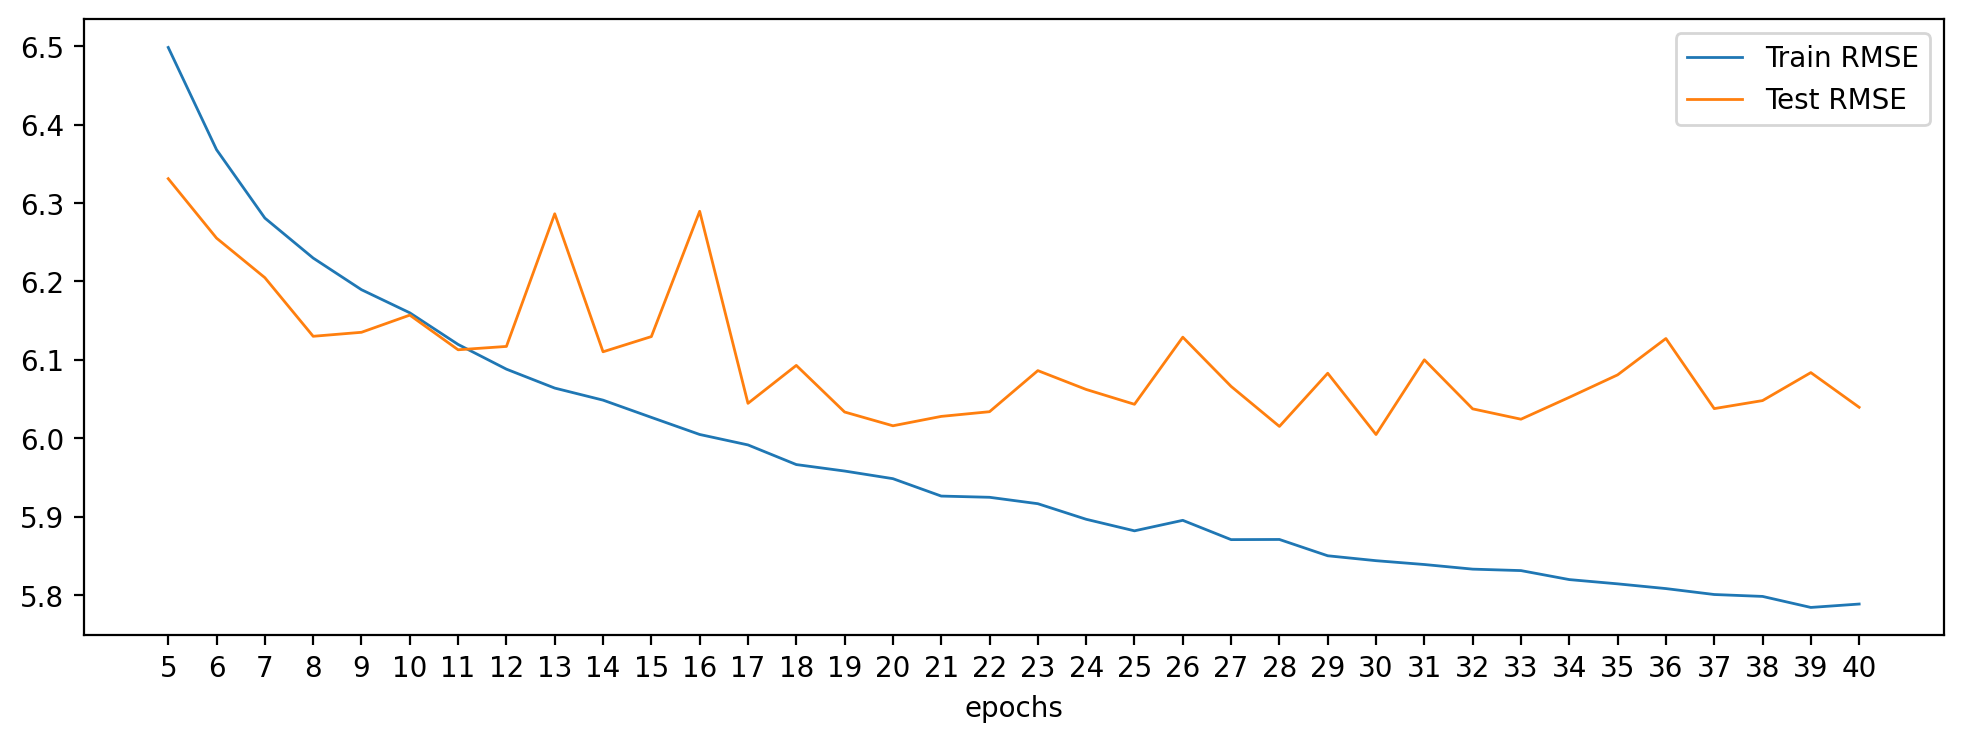

In [ ]:
fig=plt.figure(figsize=(12,4), dpi=200)

start_epoch = 5
end_epoch = 40

plt.xticks(range(start_epoch, end_epoch+1))
plt.plot(range(start_epoch, end_epoch+1), [x ** 0.5 for x in train_history[start_epoch:end_epoch+1]], label='Train RMSE', linewidth=1)
plt.plot(range(start_epoch, end_epoch+1), [x ** 0.5 for x in test_history[start_epoch:end_epoch+1]], label='Test RMSE', linewidth=1)

plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [ ]:
offset = 12000
time_steps = 4 * 24 * 60 // 5

xs = features[offset:offset+time_steps]

print(xs.shape)

model.eval()
with torch.no_grad():
  e = torch.from_numpy(edge_index).to(device)
  w = torch.from_numpy(edge_weight).to(device)

  pred = model(torch.from_numpy(xs).to(device), 12).to('cpu')

#   pred = []

#   for x in xs:
#     x = torch.from_numpy(x[np.newaxis,:,:,:]).to(device)
#     pred.append(model(x, e, w)[0,:,:].to('cpu'))

ys = targets[offset:offset+time_steps]

print(ys.shape)
print(pred.shape)

(1152, 12, 207, 1)
(1152, 12, 207, 1)
torch.Size([1152, 12, 207, 1])


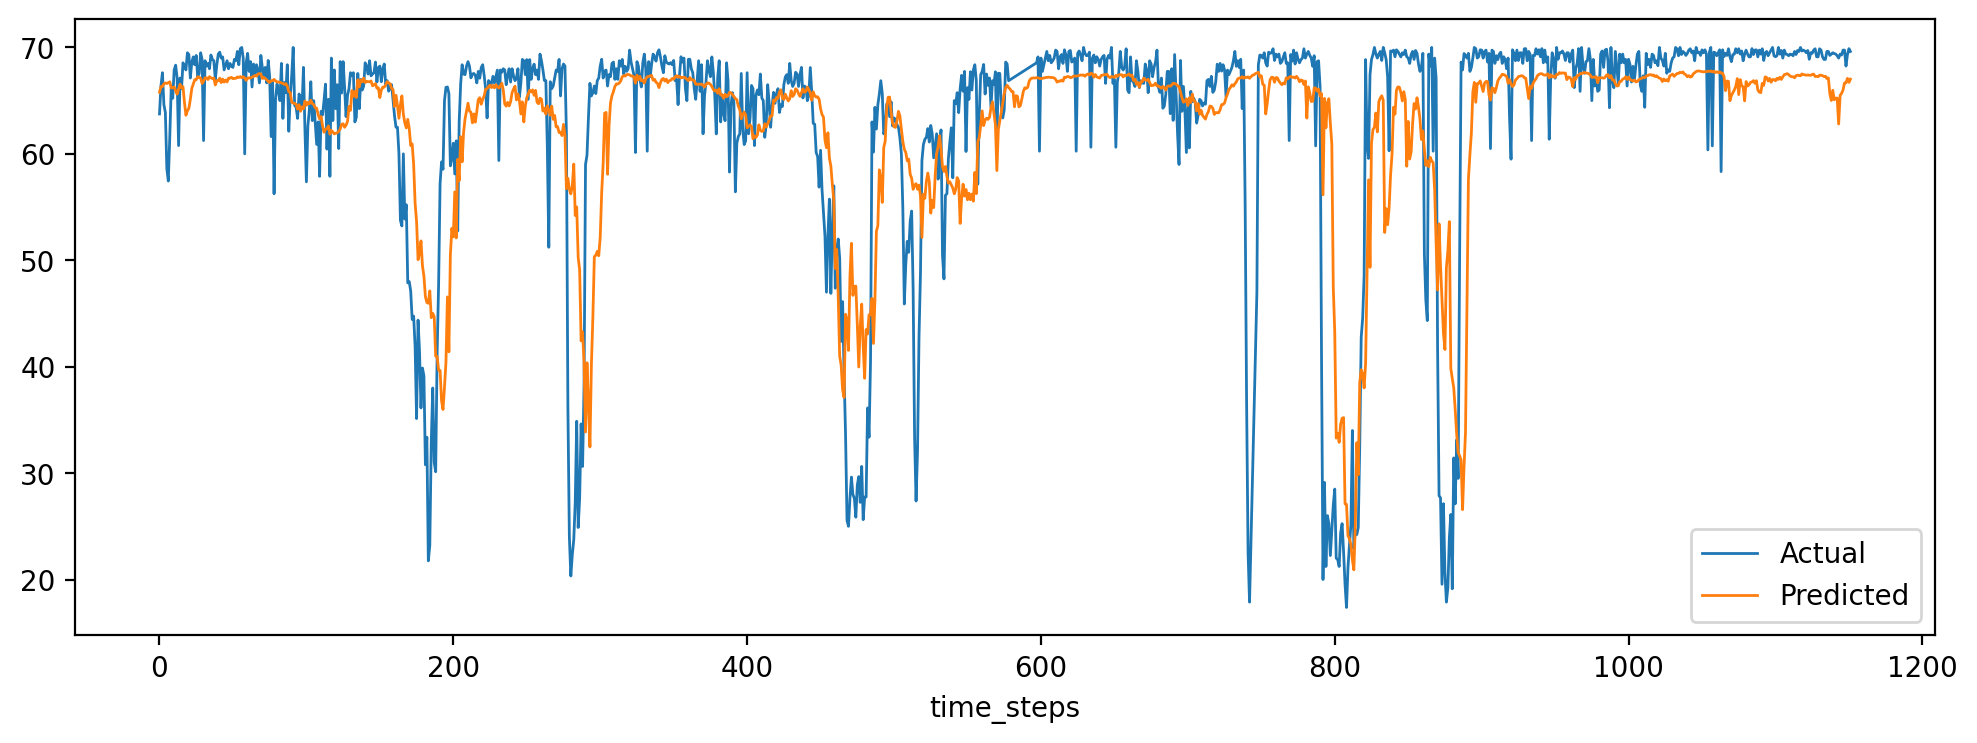

In [ ]:
sensor = 20

fig=plt.figure(figsize=(12,4), dpi=200)

plt.plot([b[-1,sensor,0] for b in ys], label='Actual', linewidth=1)
plt.plot([b[-1,sensor,0] for b in pred], label='Predicted', linewidth=1)

plt.xlabel('time_steps')
plt.legend(loc='lower right')

plt.show()

## Save Model

In [ ]:
# torch.save(model.state_dict(), 'model.pt')
# print(os.getcwd())
# print(os.listdir())
model.load_state_dict(torch.load('model_20ep.pt'))

<All keys matched successfully>